# HR-аналитика для компании «Работа с заботой».

# **ОПИСАНИЕ ПРОЕКТА**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.


Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

**ЗАДАЧИ ПРОЕКТА**

- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**ОПИСАНИЕ ДАННЫХ**

**Первая задача**

Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор сотрудника
- dept — отдел, в котором работает сотрудник
- level — уровень занимаемой должности
- workload — уровень загруженности сотрудника
- employment_years — длительность работы в компании (в годах)
- last_year_promo — показывает, было ли повышение за последний год
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель
- salary — ежемесячная зарплата сотрудника
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак

Предоставлены данные в нескольких таблицах:
- Тренировочная выборка:

train_job_satisfaction_rate.csv
- Входные признаки тестовой выборки:

test_features.csv
- Целевой признак тестовой выборки:

test_target_job_satisfaction_rate.csv


**Вторая задача**

Для этой задачи мы можем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

Данные в нескольких таблицах:
Тренировочная выборка:
- train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче:
- test_features.csv

Целевой признак тестовой выборки:
- test_target_quit.csv

**План проекта**

1. [Загрузка данных](#view)<br>
2. [Предобработка данных](#preprocessing)<br>
3. [Исследовательский анализ данных](#analiz)<br>
4. [Подготовка данных](#prepare)<br>
5. [Обучение моделей](#learn)<br>
6. [Оформление выводов](#resume)<br>
7. [Загрузка данных задача 2](#view2)<br>
8. [Предобработка данных задача 2](#preprocessing2)<br>
9. [Исследовательский анализ данных задача 2](#analiz2)<br>
10. [Добавление нового входного признака задача 2](#feature2)<br>
11. [Подготовка данных задача 2](#prepare2)<br>
12. [Обучение моделей задача 2](#learn2)<br>
13. [Оформление выводов задача 2](#resume2)<br>
14.  [ОБЩИЕ ВЫВОДЫ](#resumefinal)

In [1]:
!pip install shap -q
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import time
import phik
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    classification_report)
from phik import phik_matrix, report
from phik.report import plot_correlation_matrix
from sklearn.dummy import DummyClassifier

# Задача 1

##  Загрузка данных <a name="view"></a>

In [4]:
try:
    job_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal='.', sep=',')
    test_features = pd.read_csv('/datasets/test_features.csv', decimal='.', sep=',')
    test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal='.', sep=',') 
except:
    job_satisfaction = pd.read_csv("C:\\Users\\bkale\\Downloads\\train_job_satisfaction_rate.csv", decimal='.', sep=',')
    test_features = pd.read_csv("C:\\Users\\bkale\\Downloads\\test_features.csv", decimal='.', sep=',')
    test_target = pd.read_csv("C:\\Users\\bkale\\Downloads\\test_target_job_satisfaction_rate.csv", decimal='.', sep=',')

In [5]:
def descr (df):
    display(df.head(5))
    display(df.info()) 
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print(f'Количество пропусков: {df.isna().sum()}')

In [6]:
descr (job_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [7]:
descr (test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [8]:
descr (test_target)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
job_satisfaction_rate    0
dtype: int64


При загрузке и просмотре данных критических замечаний нет. Название колонок соответствует правилам написания. Также видим что в датасетах отсутствуют явные дубликаты. В двух таблицах есть пропуски которые обработаеи после.

##  Предобработка данных <a name="preprocessing"></a>

Просмотрим категориальные признаки на наличие скрытых дубликатов и неточностей

In [9]:
def cat_info (df):
    display (df.head())
    print(df.columns)

In [10]:
cat_info (job_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')


In [11]:
job_satisfaction['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [12]:
job_satisfaction['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [13]:
job_satisfaction['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [14]:
job_satisfaction['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [15]:
job_satisfaction['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [16]:
cat_info (test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')


In [17]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Заменим ' ' на nan.

In [18]:
#test_features['dept'] = test_features['dept'].replace(' ', np.nan)

In [19]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [20]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [21]:
#test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [22]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [23]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Просмотрели наши категориальнве данные на наличие неявных дубликатов или ошибок при заполнении - ничего подозрительного не обнаруженно.

В двух колонках заменили пустые значения на nan.

##  Исследовательский анализ данных <a name="analiz"></a>

Проведем ислледование таблицы job_satisfaction. Разделим все признаки на количественные и категориальные

In [24]:
job_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [25]:
# создадим список с числовыми переменными
num_col=['salary', 'job_satisfaction_rate']
# создадим список с названиями графиков
titles_num = ['ежемесячная зарплата сотрудника', 'уровень удовлетворённости сотрудника работой']

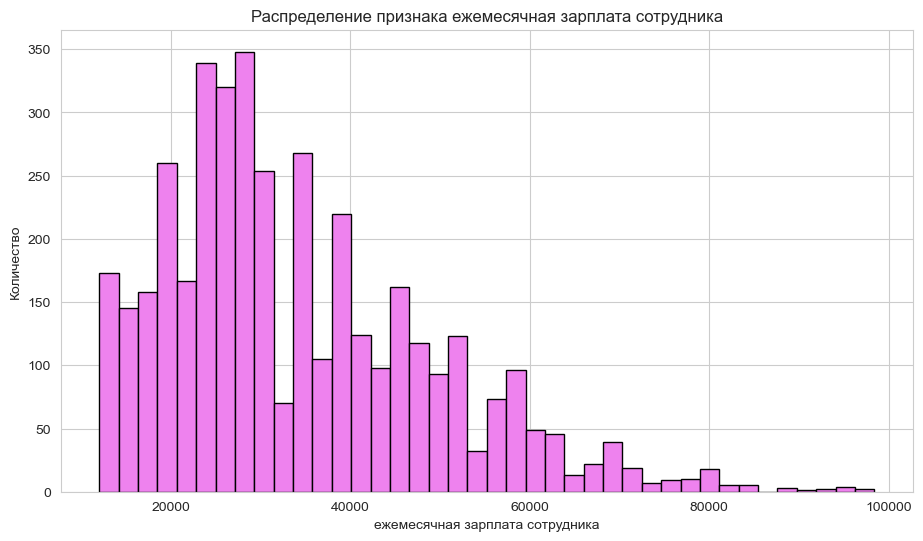

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


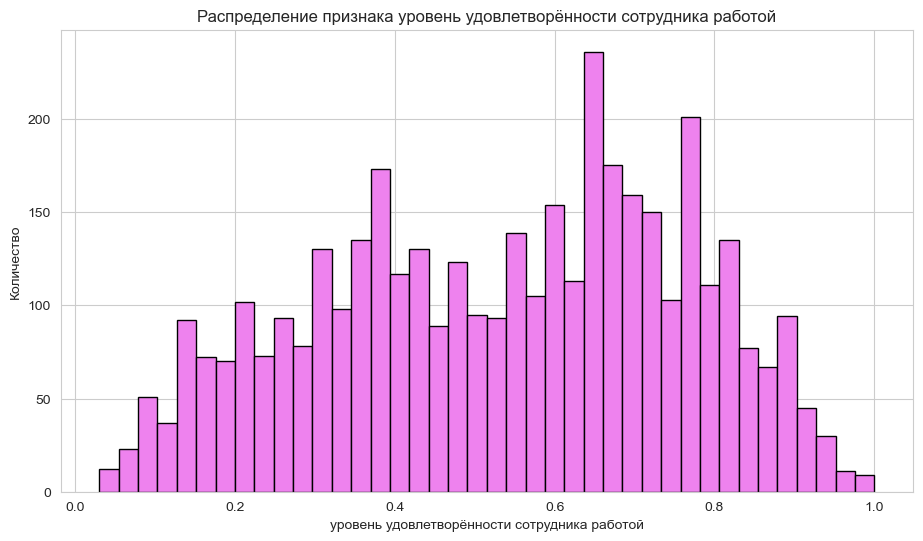

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [26]:
#Построим гистограммы и рассмотрим mean,  median, min, max
for i in range(len(num_col)):
    sns.set_style('whitegrid')
    plt.figure(figsize=(11, 6))
    plt.hist(job_satisfaction[num_col[i]], color = 'violet', edgecolor = 'black', bins = 40)
    plt.title(f"Распределение признака {titles_num[i]}")
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()
    print(job_satisfaction[num_col[i]].describe())

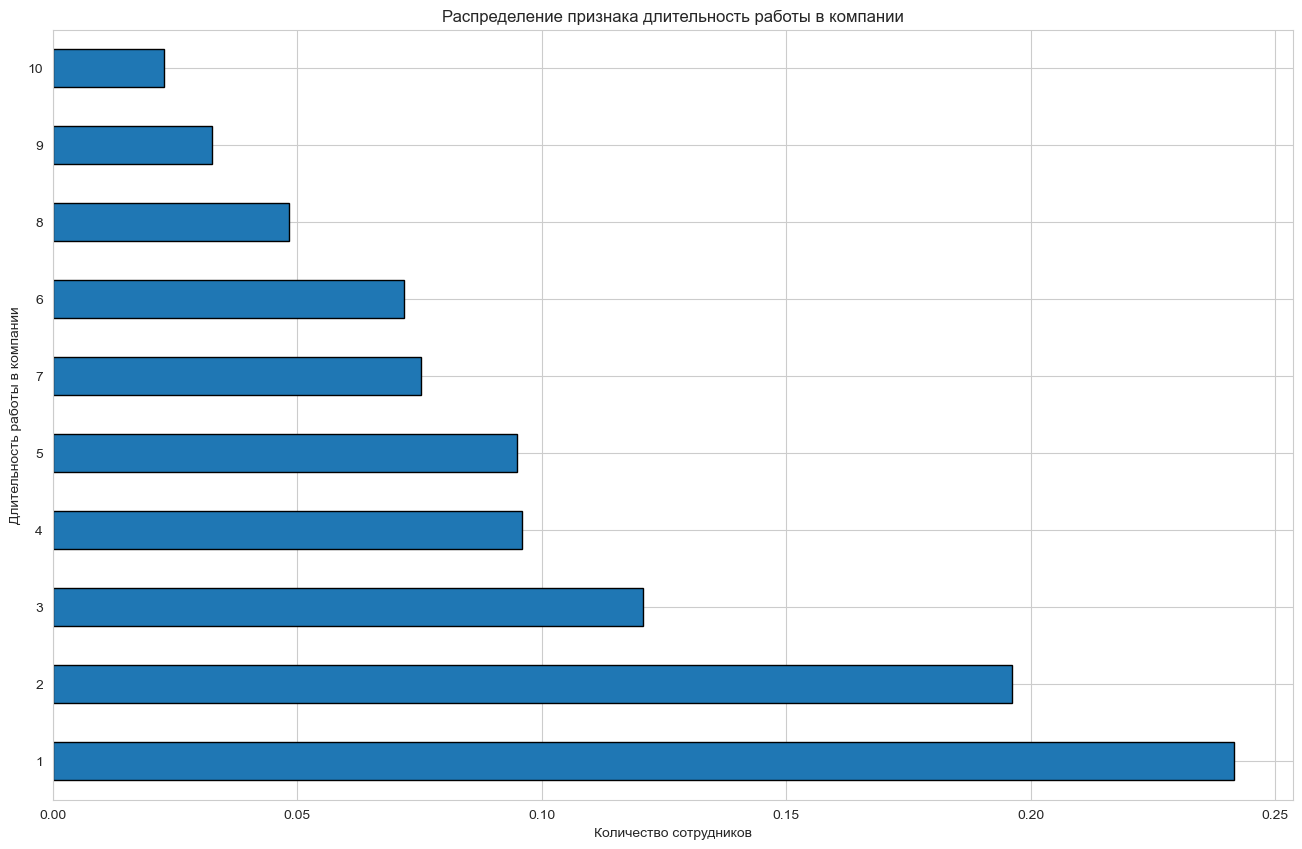

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [27]:
job_satisfaction['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака длительность работы в компании')
plt.xlabel('Количество сотрудников')
plt.ylabel('Длительность работы в компании')
plt.show()
print(job_satisfaction['employment_years'].describe())

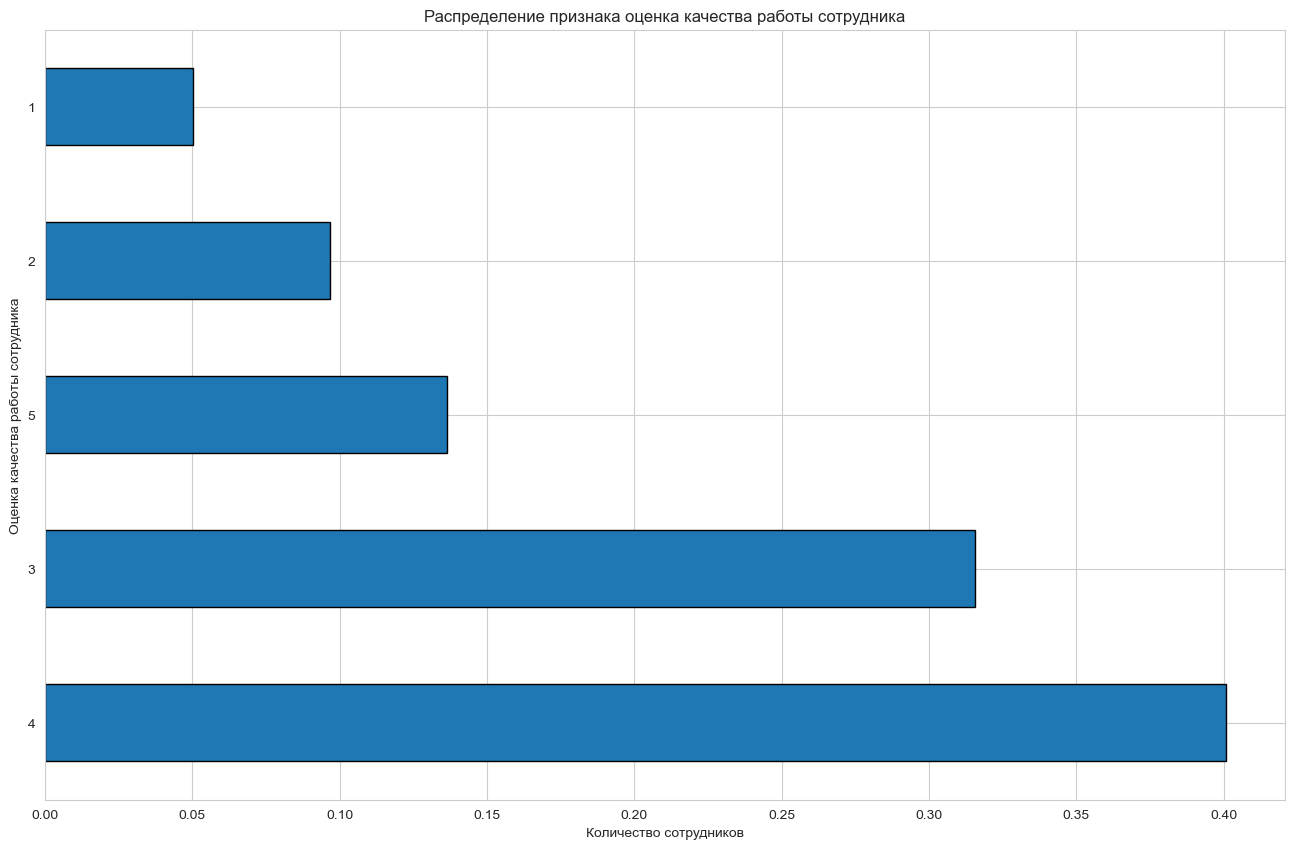

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [28]:
job_satisfaction['supervisor_evaluation'].value_counts(normalize=True).plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы сотрудника')
plt.show()
print(job_satisfaction['supervisor_evaluation'].describe())

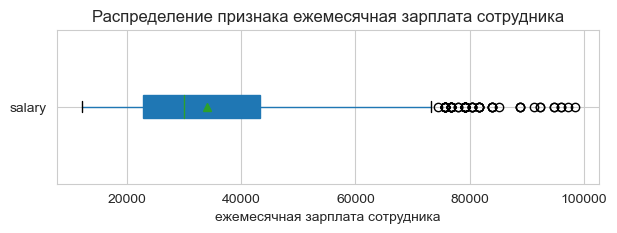

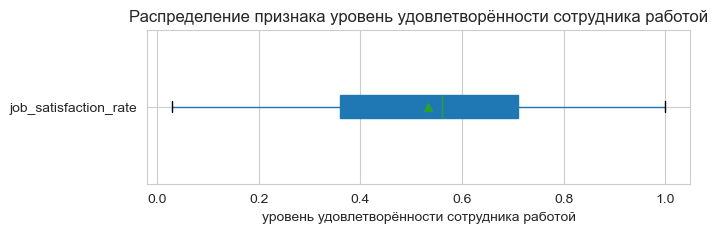

In [29]:
for i in range(len(num_col)):
    plt.figure(figsize=(7, 2))
    job_satisfaction.boxplot(num_col[i], patch_artist=True, vert=False, showmeans=True )
    plt.title(f"Распределение признака {titles_num[i]}")
    plt.xlabel(titles_num[i])
    plt.show()

После проведенного исследования можно сделать следующие выводы:
- основное число работников работают в компании от 1 до 6 лет. В среднем рабочей стаж в компании  составляет 3 года. 
- стоит отметить что оценка качества сотрудников — хороший середнячок : в основном сотрудники оцениваются на 3 и 4 бала. Но есть и те у кого оценка равна 1. Бар плот показывает что это один человек( кандидат на увольнение).
- несмотря на несколько выбросов средняя зарплата не намного больше медианной и составляет 33 926.70 тысяч рублей. С максимальной в 98400 и минимальной — 12000.
- удовлетворенность сотрудника работой соответствует оценке качества — хороший середнячок. В целом условия и работа неплохие, но можно и лучше.

In [30]:
# создадим список с категориальных перемен
cat_col=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# создадим список с названиями графиков 
titles_cat_col= ['Отдел, в котором работает сотрудник', 'Уровень занимаемой должности', 'Уровень загруженности сотрудника', 'Было ли повышение за последний год', 'Нарушал ли сотрудник трудовой договор за последний год']

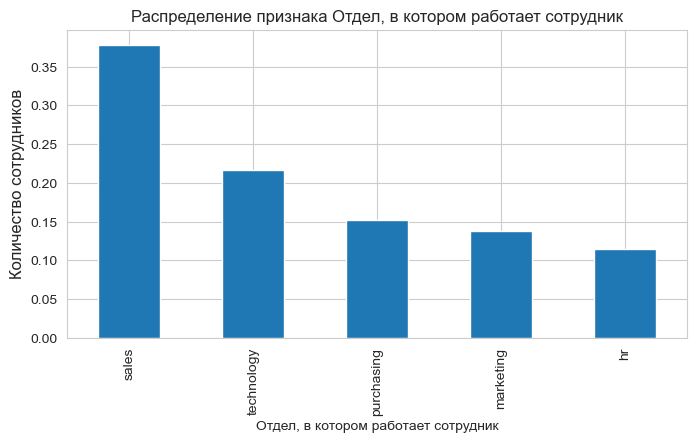

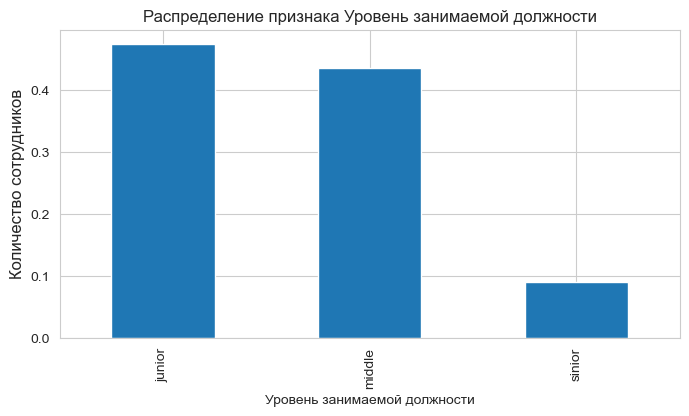

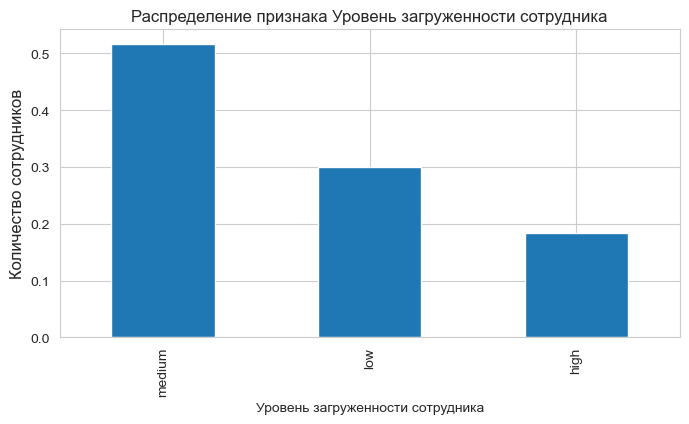

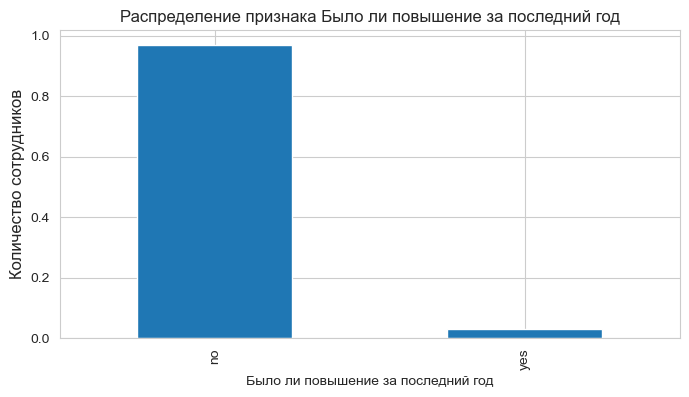

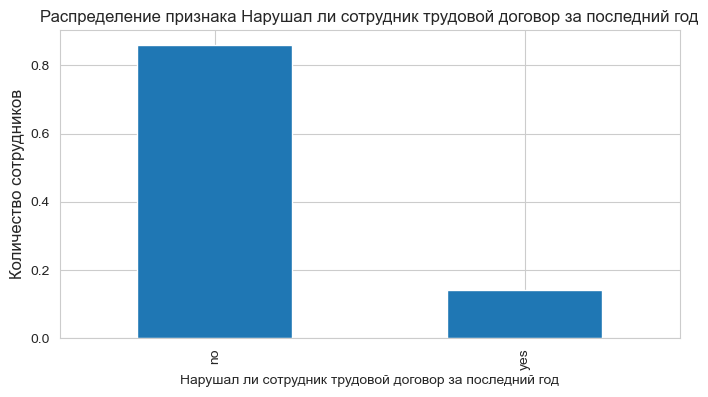

In [31]:
for i in range(len(cat_col)):
    plt.figure(figsize=(8, 4))
    job_satisfaction[cat_col[i]].value_counts(normalize=True).plot.bar()
    plt.title(f"Распределение признака {titles_cat_col[i]}")
    plt.ylabel('Количество сотрудников', size=12)
    plt.xlabel(titles_cat_col[i]) 
    plt.show()
    

    

По категориальным признакам можно сделать следующие выводы:
- основное число работников составляют продавцы, на втором месте технологический отдел;
-  по уровню занимаемой должности , все выглядит так как должно -основное число сотрудников это junior, но стоит отметить также значительное число среднего уровня;
- загруженность персонала , также находится в основном на среднем уровне, но компании стоит обратить внимание на достаточно высокий уровень мало загруженных сотрудников.
- видим что в компании за последний год практически не было повышения, что достаточно логично учитывая средний стаж работников — 3 года., но с другой стороны повышения можно использовать как дополнительный стимул для повышения производительности труда.
- по дисциплине стоит отметить достаточно низкий уровень нарушений трудового договора, но все же они есть. Стоит обратить внимание на них и носят ли эти нарушения систематический характер.

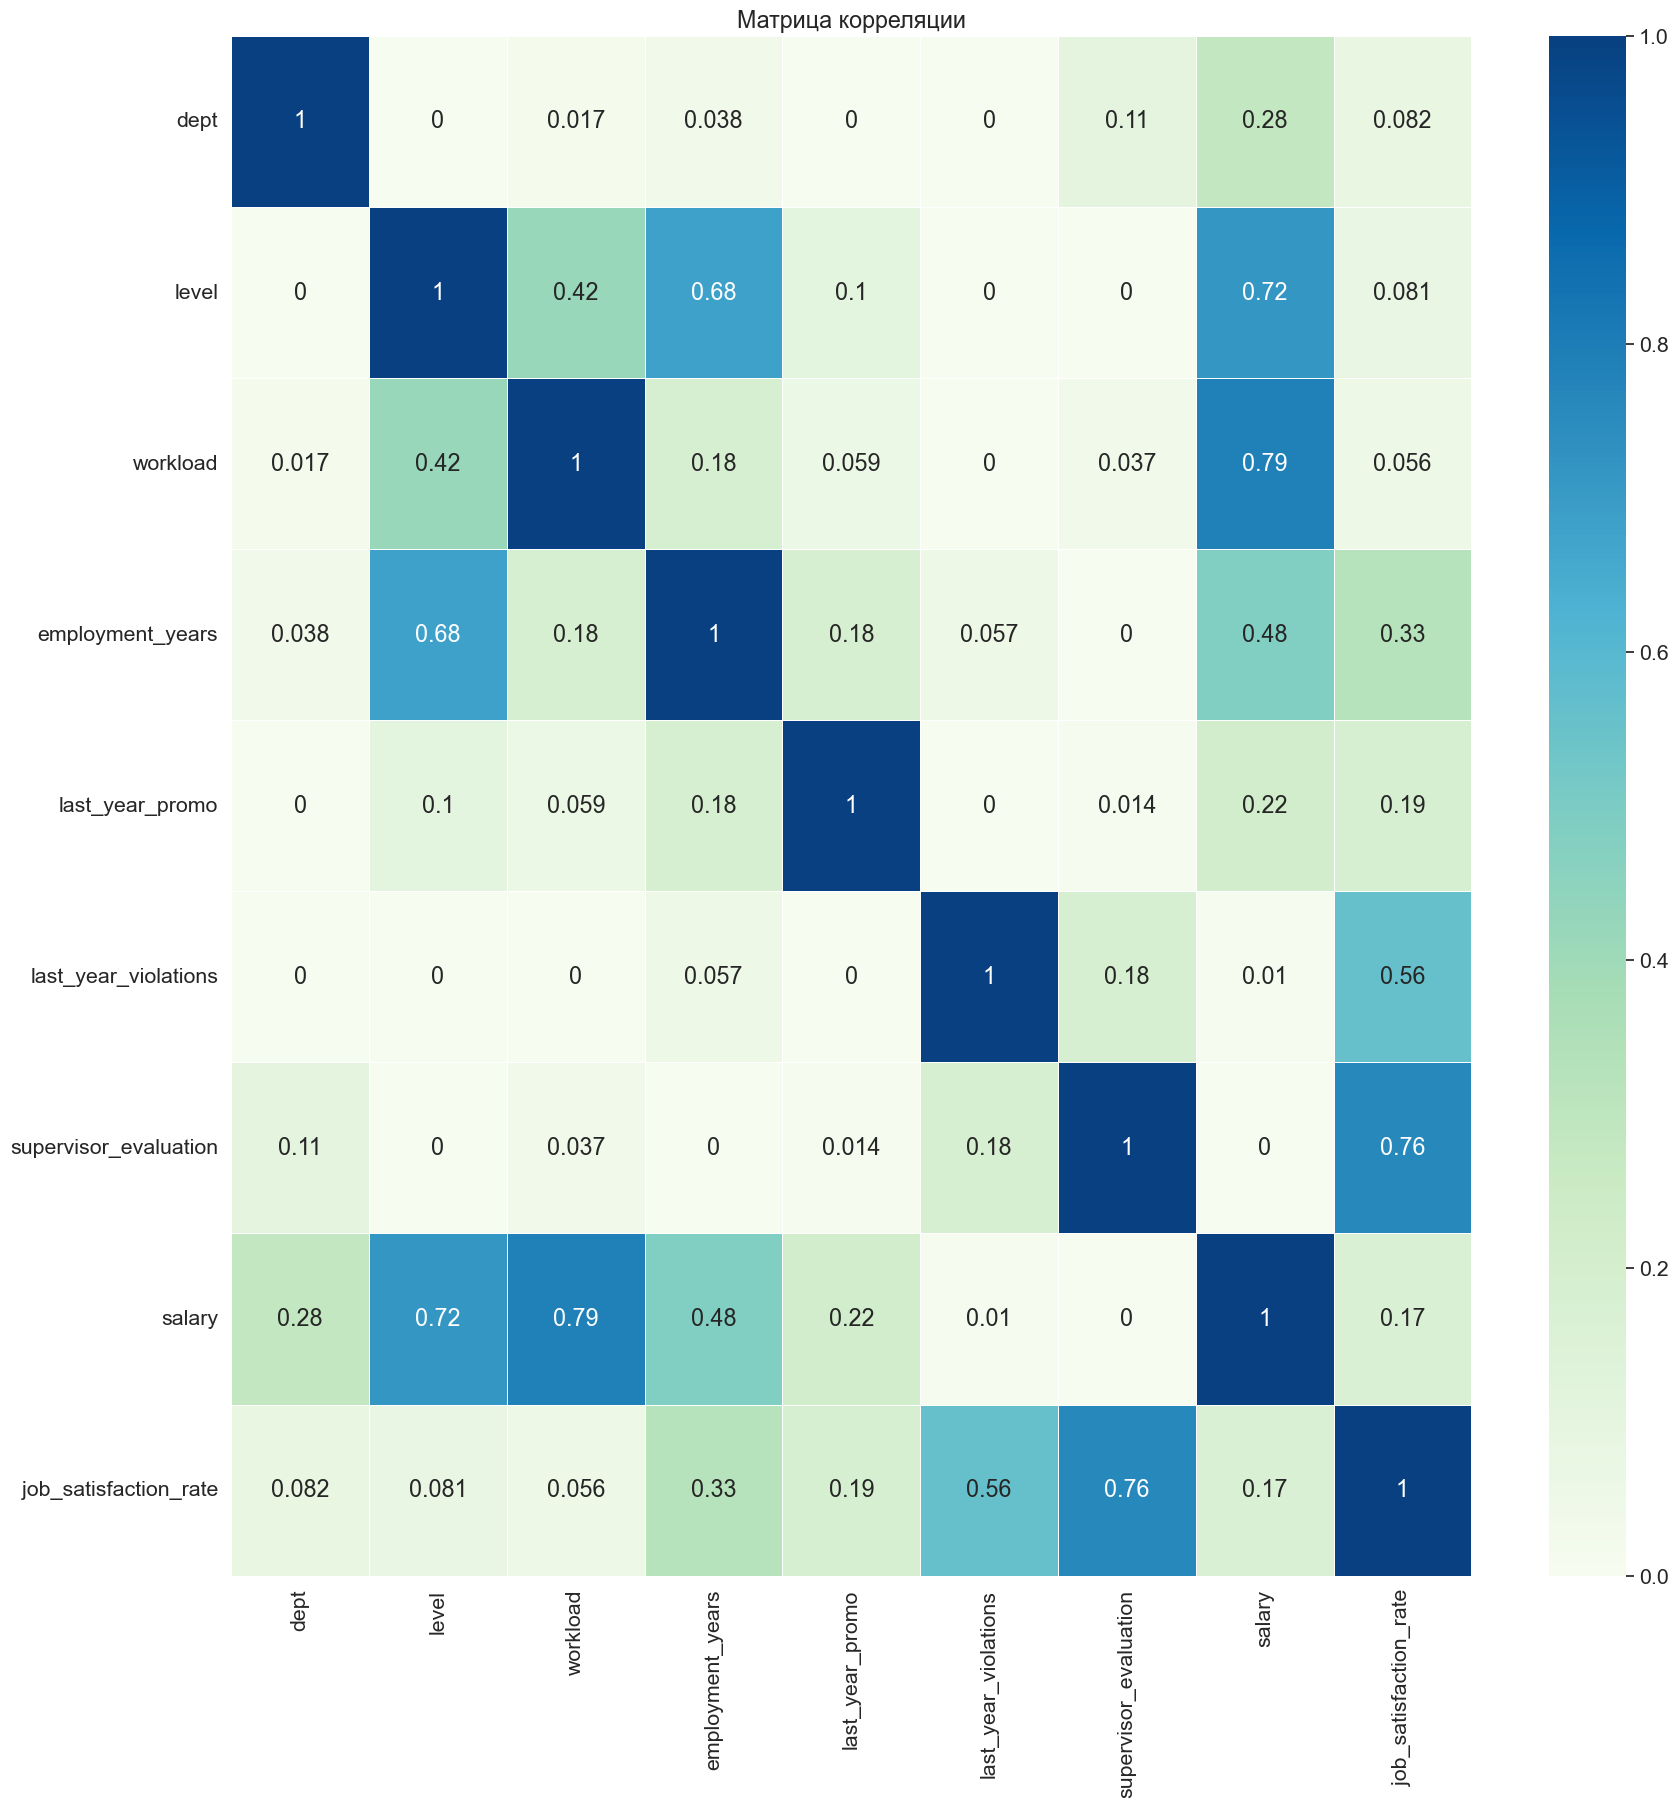

In [32]:
job_satisfaction_1=job_satisfaction.drop(['id'], axis=1)
corr_matrix = job_satisfaction_1.phik_matrix(interval_cols = num_col)
sns.set(font_scale=1.4)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
plt.title('Матрица корреляции')
plt.show()

По корреляционному анализу можно сказать следующие: высокий уровень корреляции между целевым признаком - уровень удовлетворённости сотрудника работой в компании и отделом, в котором работает сотрудник, уровнем занимаемой должности  а также оценка качества работы сотрудника. Но тем не менее сильной корреляционой зависимости между признаками нет. В нашем случае мультиколлинеарность отсутствует. Поэтому ничего удалять не будем.

In [33]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [34]:
# создадим список с числовыми переменными
num_col_1=['salary']
# создадим список с названиями графиков
titles_num_1 = ['ежемесячная зарплата сотрудника']

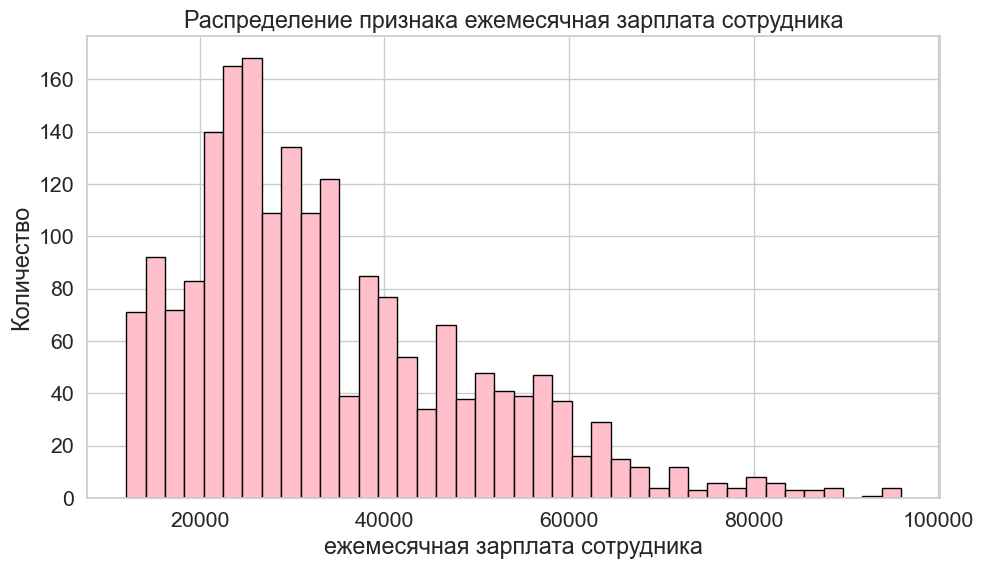

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [35]:
#Построим гистограммы и рассмотрим mean,  median, min, max
for i in range(len(num_col_1)):
    sns.set_style('whitegrid')
    plt.figure(figsize=(11, 6))
    plt.hist(test_features[num_col_1[i]], color = 'pink', edgecolor = 'black', bins = 40)
    plt.title(f"Распределение признака {titles_num_1[i]}")
    plt.ylabel("Количество")
    plt.xlabel(titles_num_1[i])
    plt.show()
    print(test_features[num_col_1[i]].describe())

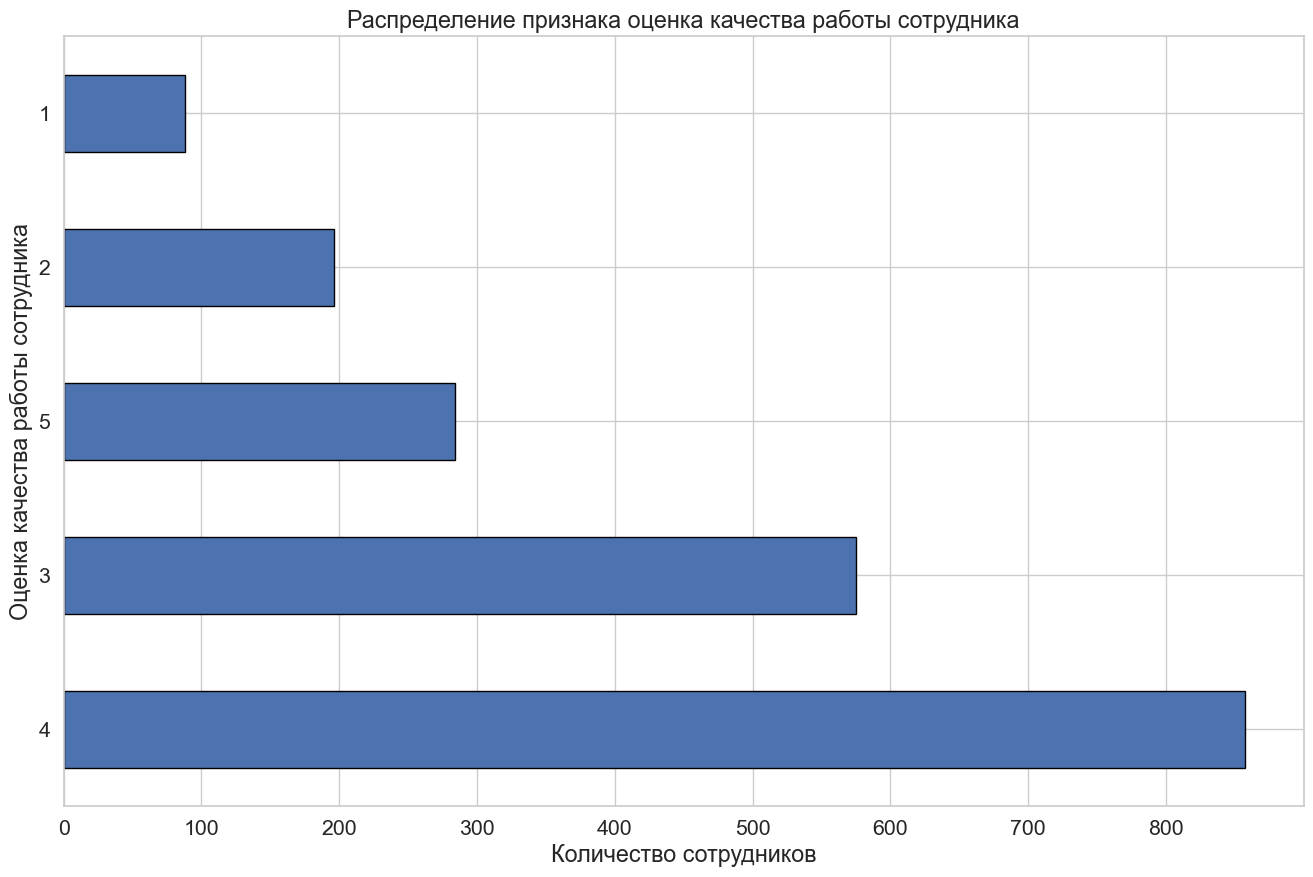

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [36]:
test_features['supervisor_evaluation'].value_counts().plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы сотрудника')
plt.show()
print(test_features['supervisor_evaluation'].describe())

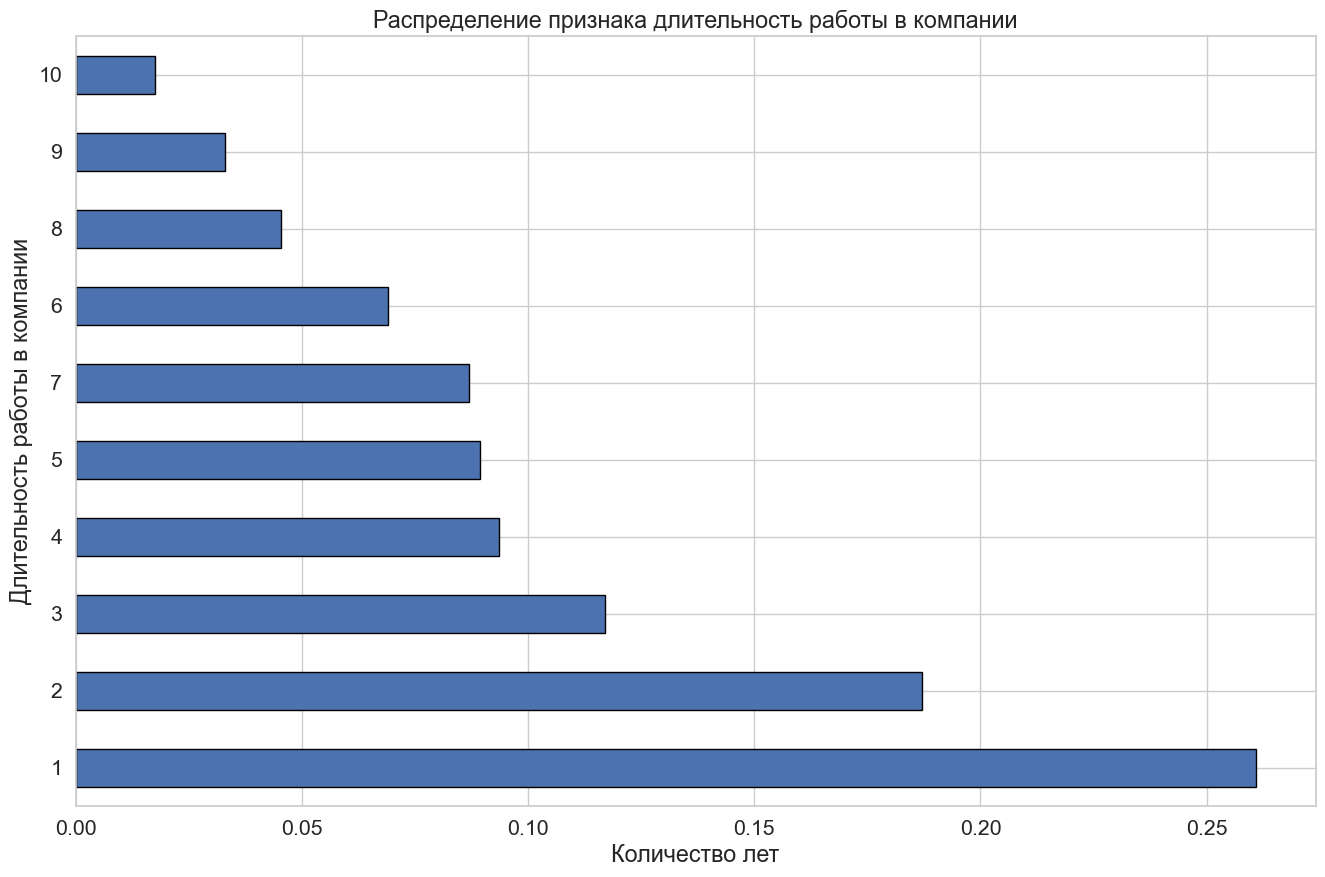

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [37]:
test_features['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака длительность работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Длительность работы в компании')
plt.show()
print(test_features['employment_years'].describe())

In [38]:
# создадим список с категориальных перемен
cat_col_1=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# создадим список с названиями графиков 
titles_cat_col_1= ['отдел, в котором работает сотрудник', 'уровень занимаемой должности', 'уровень загруженности сотрудника', 'Было ли повышение за последний год', 'нарушал ли сотрудник трудовой договор за последний год']

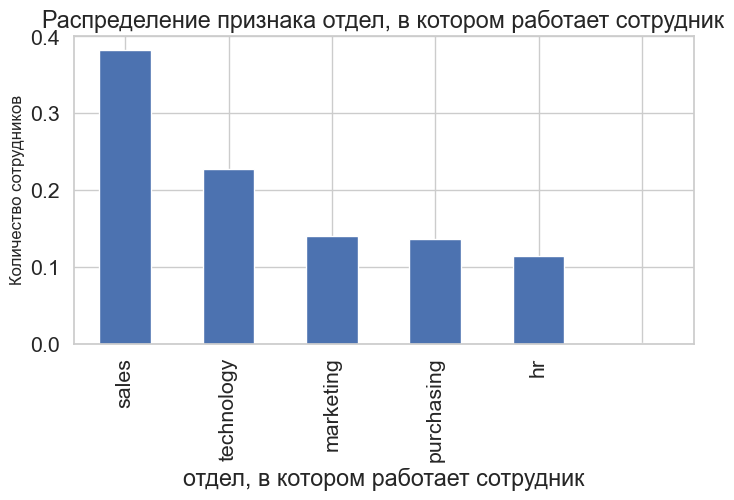

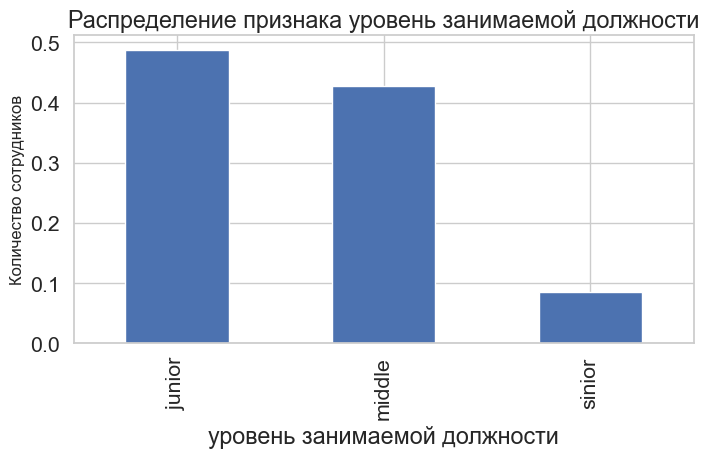

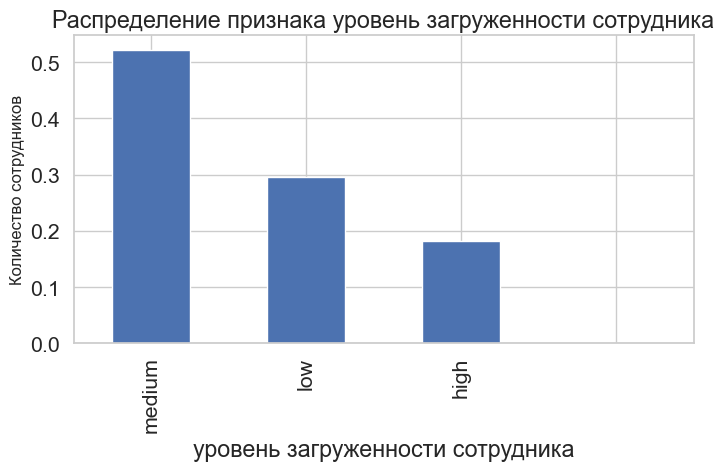

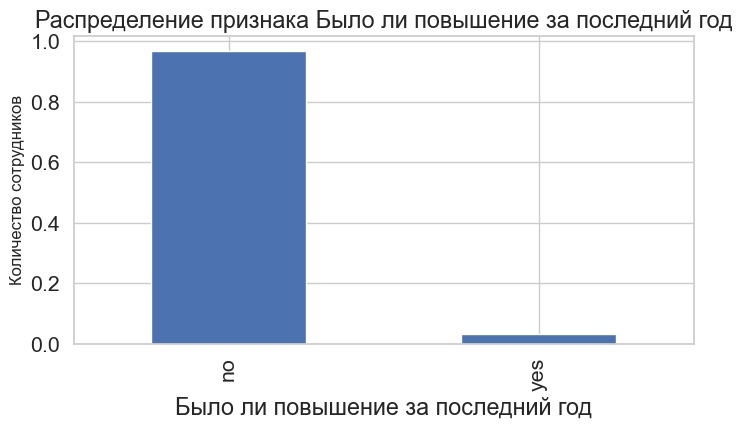

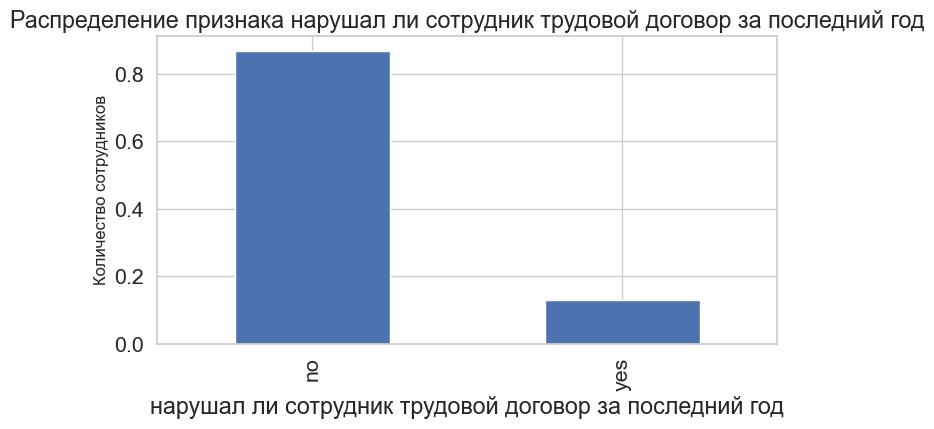

In [39]:
for i in range(len(cat_col)):
    plt.figure(figsize=(8, 4))
    test_features[cat_col_1[i]].value_counts(normalize=True).plot.bar()
    plt.title(f"Распределение признака {titles_cat_col_1[i]}")
    plt.xlabel(titles_cat_col_1[i])
    plt.ylabel('Количество сотрудников', size=12)
    plt.show()

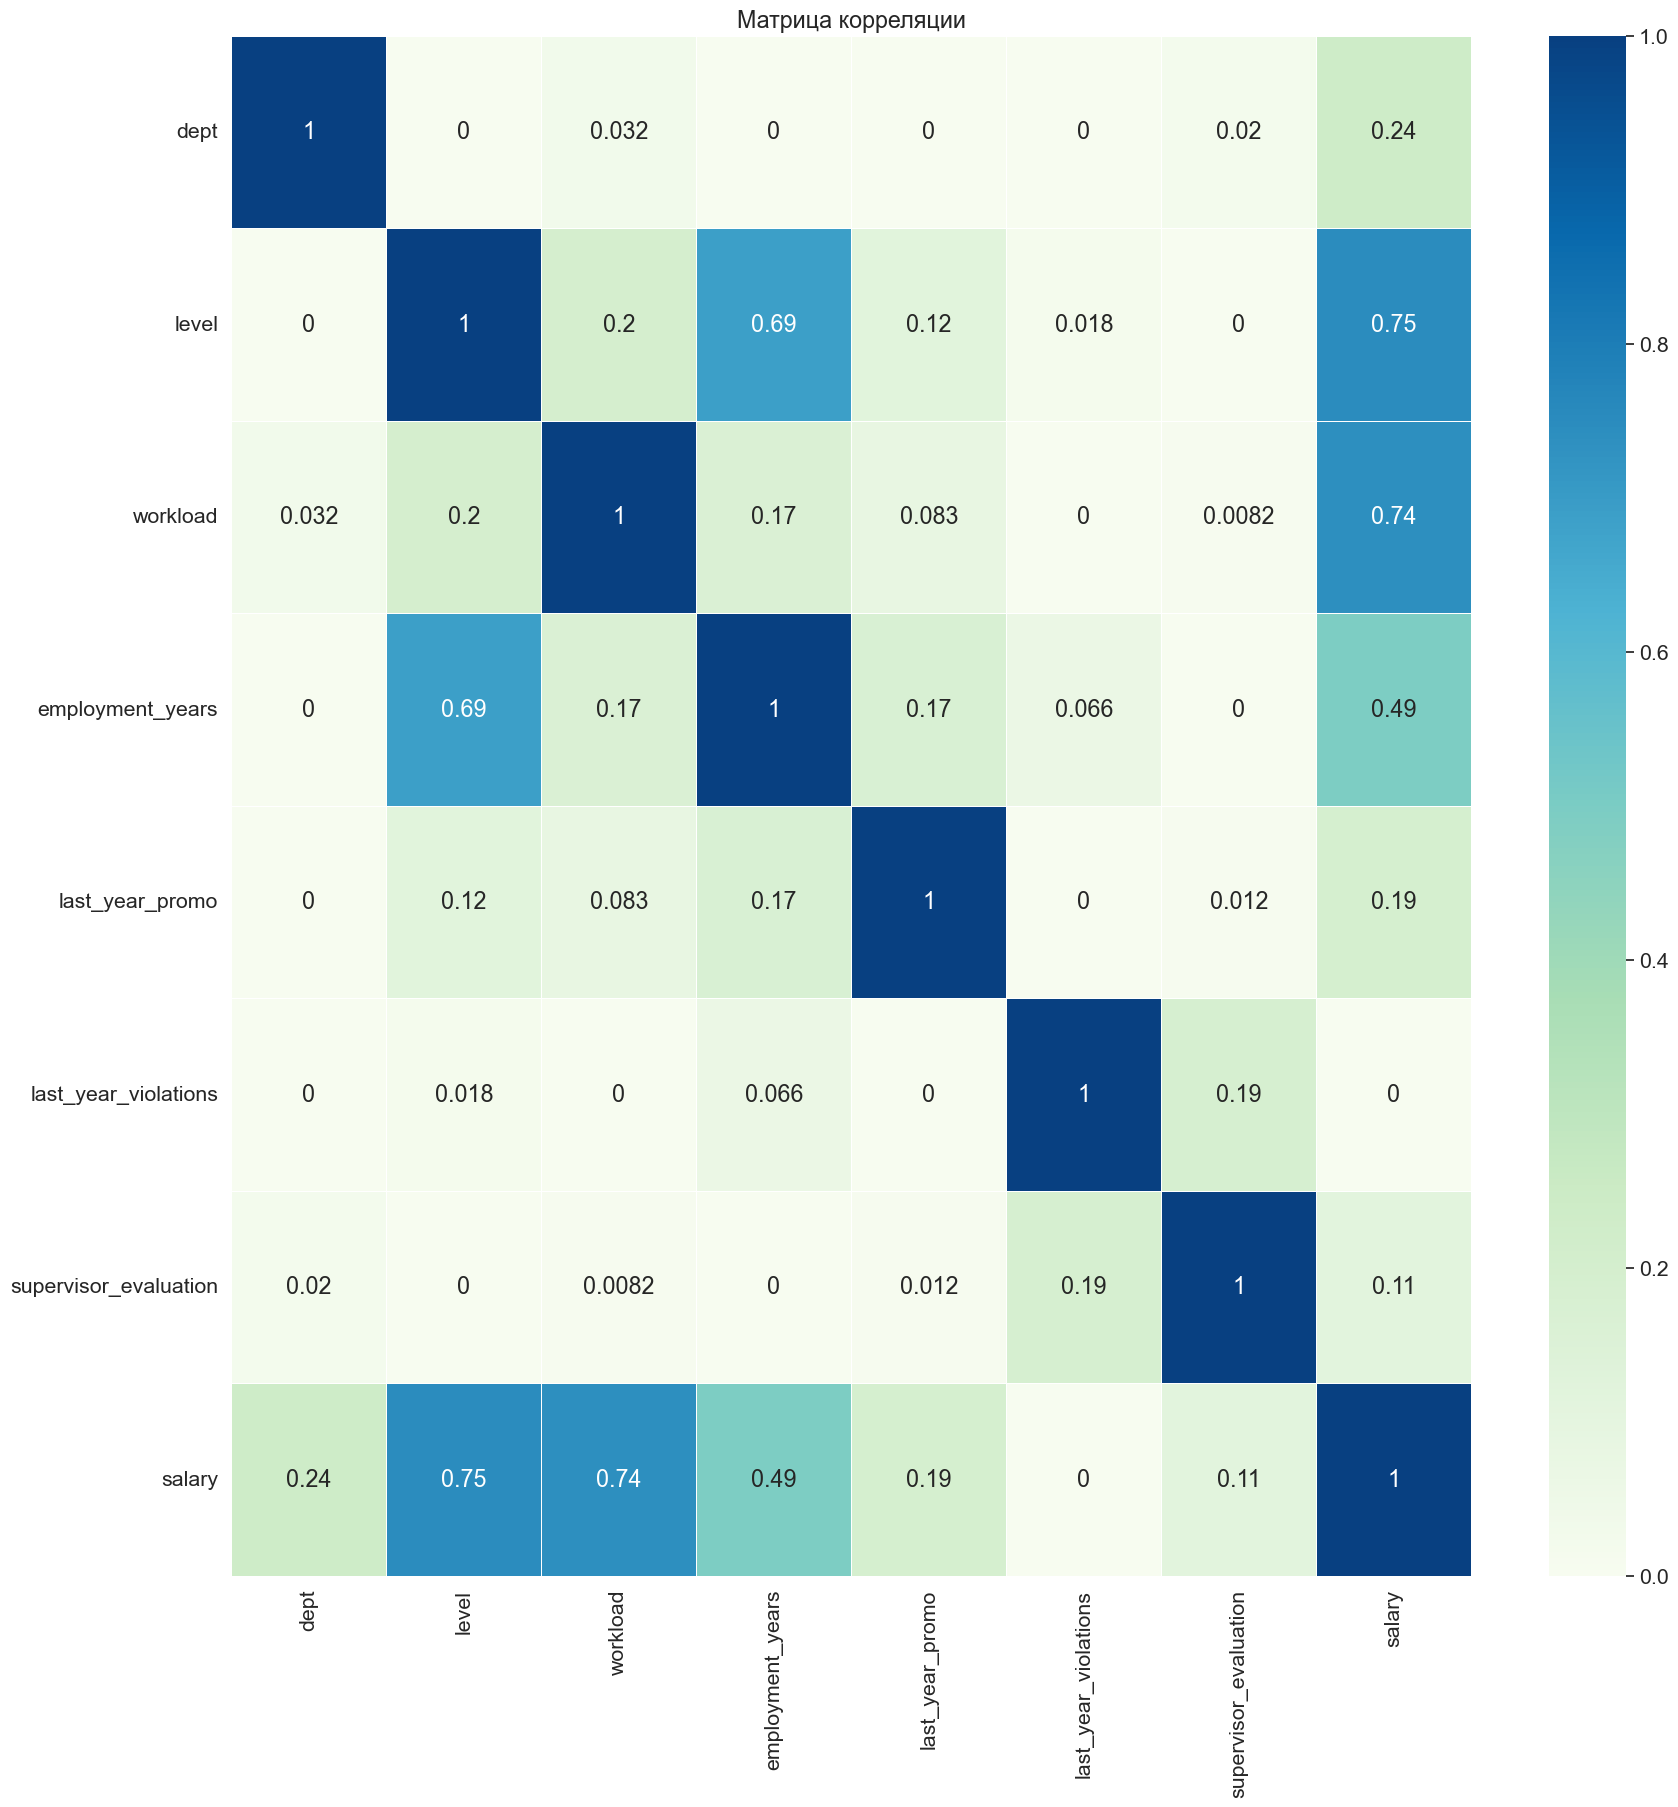

In [40]:
test_features_1=test_features.drop(['id'], axis=1)
corr_matrix = test_features_1.phik_matrix (interval_cols = num_col)
sns.set(font_scale=1.4)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
plt.title('Матрица корреляции')
plt.show()

При анализе выборки без целевого признака особых изменений не заметили. 

##   Подготовка данных <a name="prepare"></a>

Подготовку проведём в пайплайне. Подготовка данных:
- dept, last_year_promo, last_year_violations — будем кодировать с помощью OneHotEncoder.
- level, workload — с помощью OrdinalEncoder.
- employment_years, supervisor_evaluation, salary - нужно масштабировать.

##  Обучение моделей <a name="learn"></a>

Наши данные изначально были поделены на тренировачную, тестовую и целевую тестовую. 

In [41]:
train_1 = job_satisfaction.drop(['id'], axis=1)
train_1.drop_duplicates(inplace=True)



In [42]:
RANDOM_STATE = 100
TEST_SIZE = 0.25
X_train = train_1.drop('job_satisfaction_rate', axis=1)
y_train = train_1['job_satisfaction_rate'] 


# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
 
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'models__min_samples_split': range(2, 21),
        'models__max_features': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]


def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))



smape_scorer = make_scorer(score_func=smape, greater_is_better=False)
 
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=10,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

# выводим на экран лучшую модель
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [43]:
test_features = test_features.merge(test_target, on='id', how='left')
X_test = test_features.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_features['job_satisfaction_rate']
best_model = r_search.best_estimator_
print(f'Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: {round(r_search.best_score_*(-1),4)}')

Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 15.1814


In [44]:
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),4)}')

Метрика sMAPE лучшей модели на тестовой выборке: 13.6159


##   Оформление выводов <a name="resume"></a>

Мы провели обучение модели. Был построен пайплайн с использование:DecisionTreeClassifier(),LinearRegression().


 Параметры лучшей модели:
- {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 12, 'models__max_features': 10, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=100)}
- Метрика лучшей модели на тренировочной выборке: -15.18
- Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 15.1814
- Метрика sMAPE лучшей модели на тестовой выборке: 13.6159

# Задача 2

##  Загрузка данных задача 2 <a name="view2"></a>

In [45]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv("C:\\Users\\bkale\\Downloads\\train_quit.csv", decimal='.', sep=',')
    test_features = pd.read_csv("C:\\Users\\bkale\\Downloads\\test_features.csv", decimal='.', sep=',')
    test_target_quit = pd.read_csv("C:\\Users\\bkale\\Downloads\\test_target_quit.csv", decimal='.', sep=',')

In [46]:
descr(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [47]:
descr(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [48]:
descr(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Количество дубликатов: 0
Количество пропусков: id      0
quit    0
dtype: int64


При загрузке и просмотре данных критических замечаний нет. Название колонок соответствует правилам написания. Также видим что в датасетах отсутствуют явные дубликаты. В двух таблицах есть пропуски которые обработаеи после.

## Предобработка данных задача 2 <a name="preprocessing2"></a>

In [49]:
for col in train_quit.iloc[:, 1:8]:
    print(train_quit[col].unique ())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
[ 2  5  1  8  4  7  3  9  6 10]
['no' 'yes']
['no' 'yes']
[4 1 3 5 2]


In [50]:
for col in test_features.iloc[:, 1:8]:
    print(test_features[col].unique ())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]


Заменим ' ' на nan.

In [51]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

Просмотрели наши категориальнве данные на наличие неявных дубликатов или ошибок при заполнении - ничего подозрительного не обнаруженно.

В двух колонках заменили пустые значения на nan.

## Исследовательский анализ данных задача 2 <a name="analiz2"></a>

In [52]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [53]:
# создадим список с числовыми переменными
num_col_2=['salary']
# создадим список с названиями графиков
titles_num_2 = ['ежемесячная зарплата сотрудника']

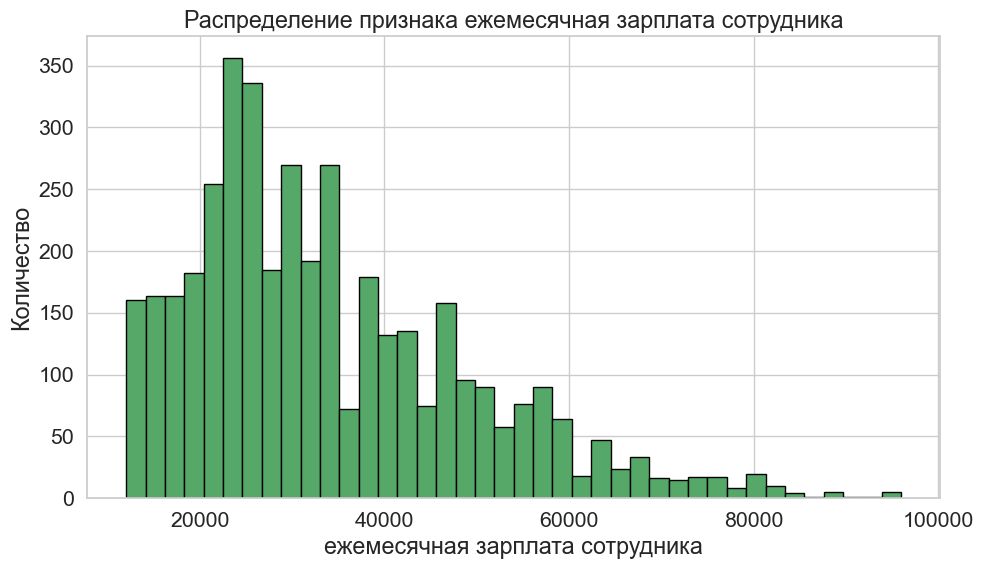

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [54]:
#Построим гистограммы и рассмотрим mean,  median, min, max
for i in range(len(num_col_2)):
    sns.set_style('whitegrid')
    plt.figure(figsize=(11, 6))
    plt.hist(train_quit[num_col_2[i]], color = 'g', edgecolor = 'black', bins = 40)
    plt.title(f"Распределение признака {titles_num[i]}")
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()
    print(train_quit[num_col_2[i]].describe())

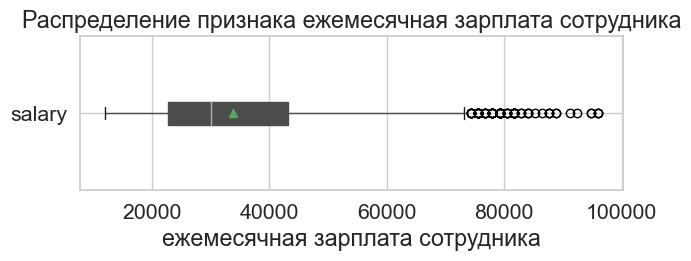

In [55]:
for i in range(len(num_col_2)):
    plt.figure(figsize=(7, 2))
    train_quit.boxplot(num_col_2[i], patch_artist=True, vert=False, showmeans=True )
    plt.title(f"Распределение признака {titles_num_2[i]}")
    plt.xlabel(titles_num_2[i])
    plt.show();

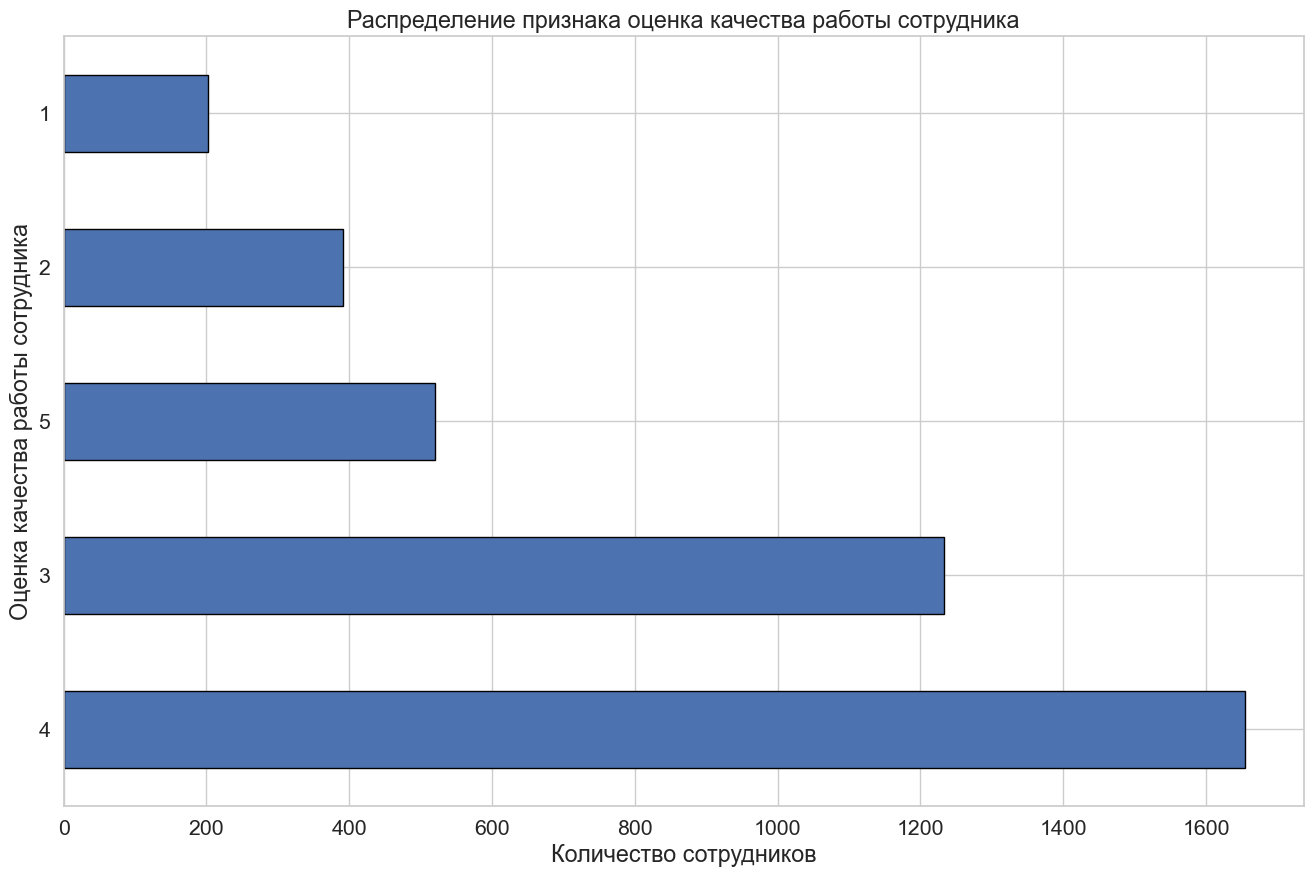

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [56]:
train_quit['supervisor_evaluation'].value_counts().plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы сотрудника')
plt.show()
print(train_quit['supervisor_evaluation'].describe())

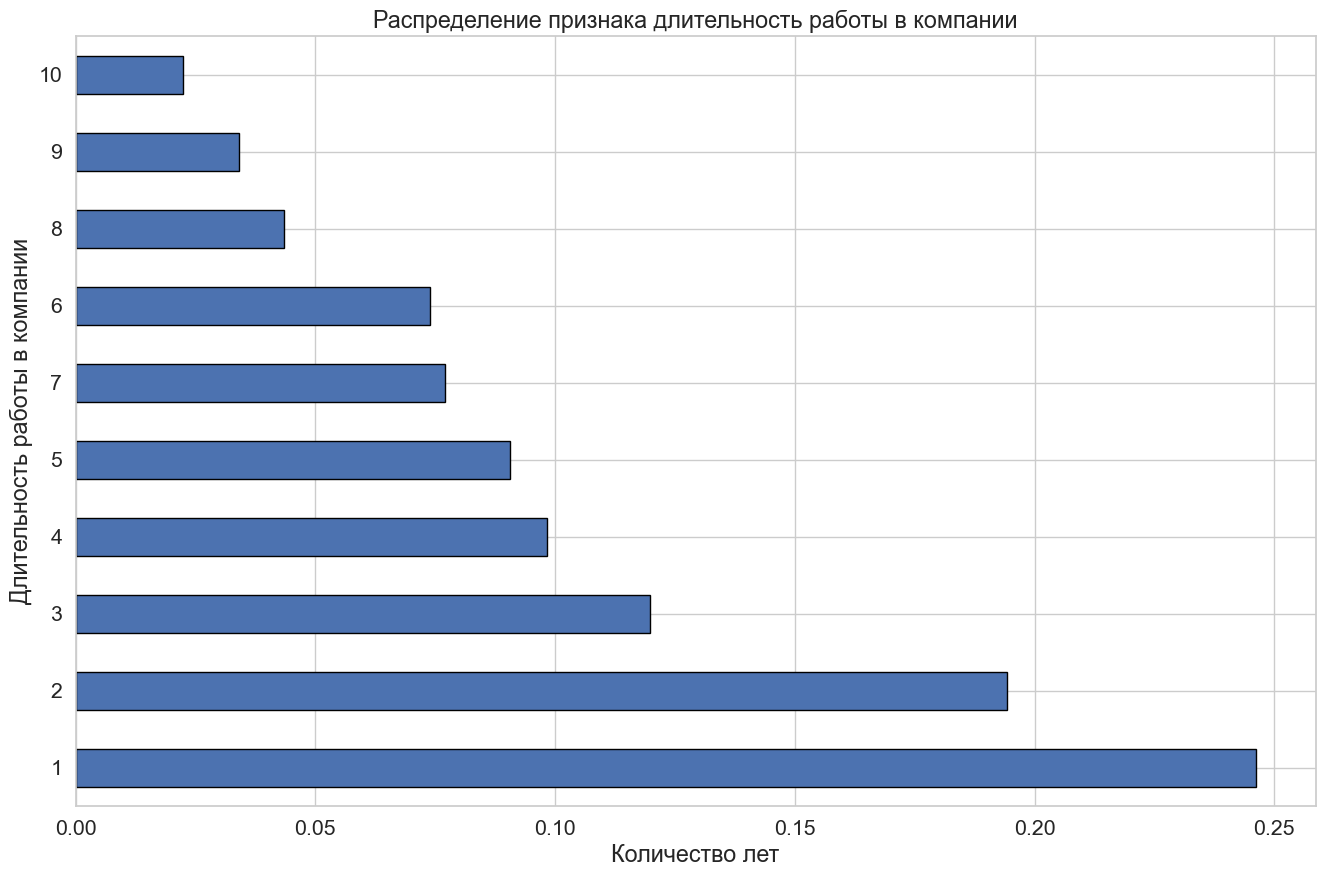

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [57]:
train_quit['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака длительность работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Длительность работы в компании')
plt.show()
print(train_quit['employment_years'].describe())

In [58]:
# создадим список с категориальных перемен
cat_col_2=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
# создадим список с названиями графиков 
titles_cat_col_2= ['отдел, в котором работает сотрудник', 'уровень занимаемой должности', 'уровень загруженности сотрудника', 'было ли повышение за последний год', 'нарушал ли сотрудник трудовой договор за последний год', ' увольнение сотрудника из компании']

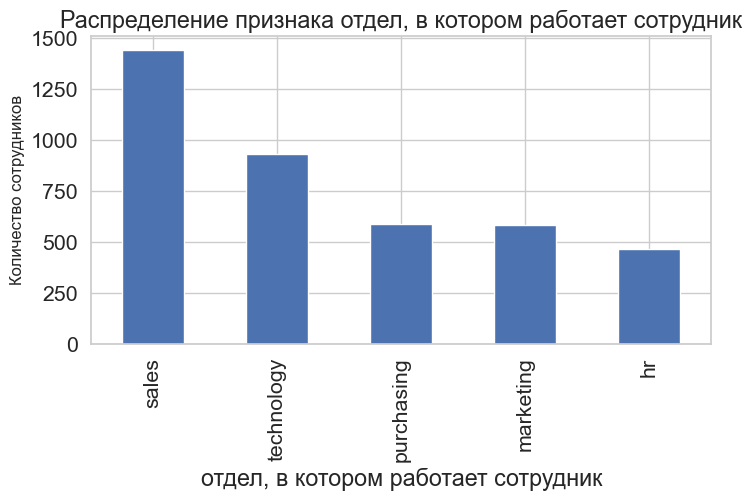

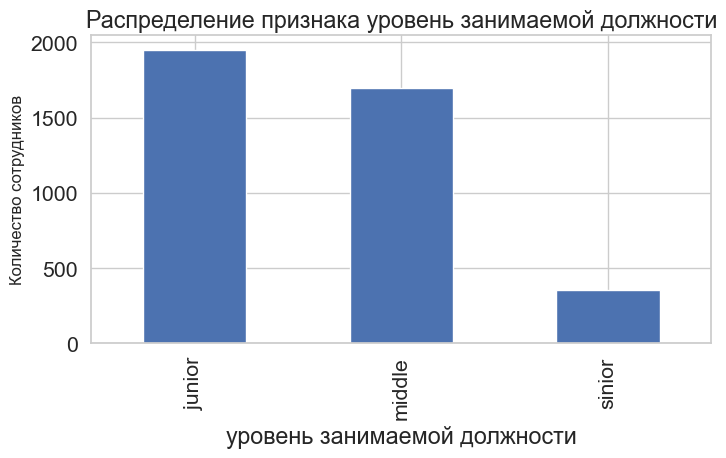

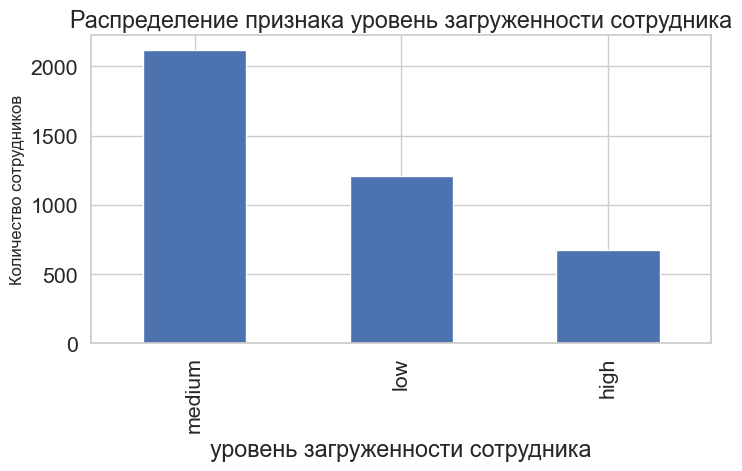

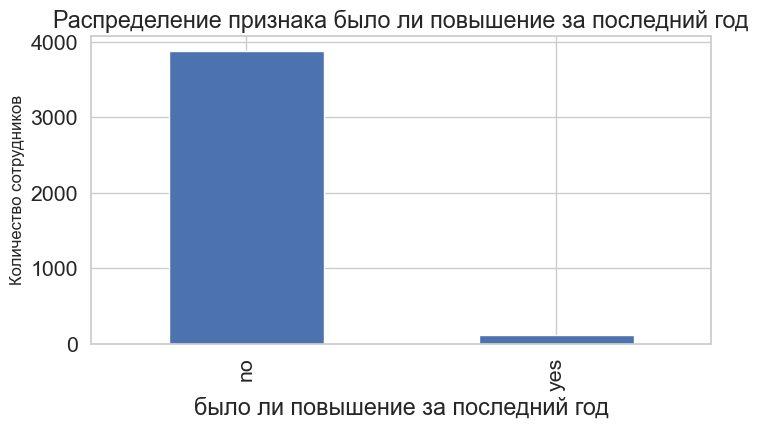

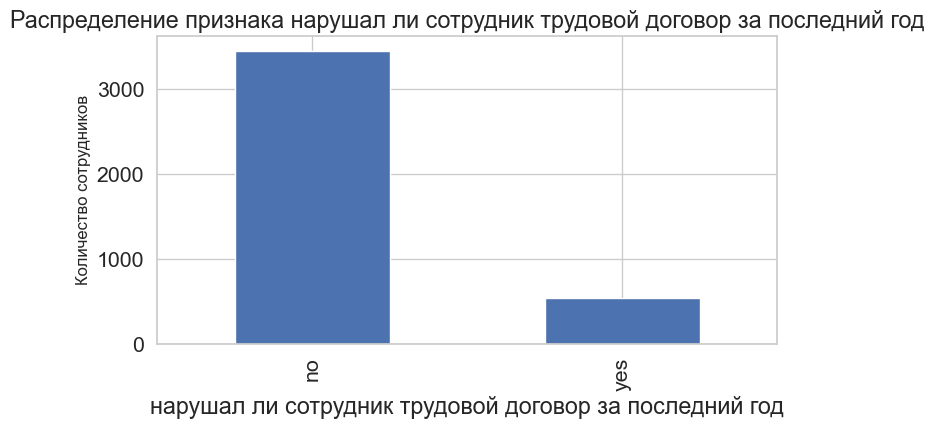

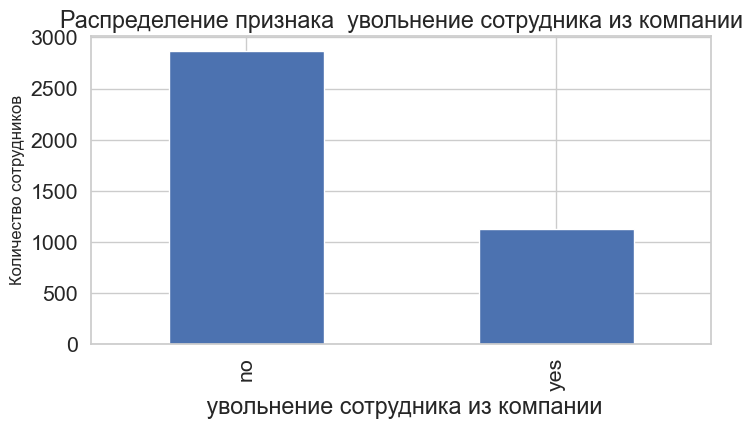

In [59]:
for i in range(len(cat_col_2)):
    plt.figure(figsize=(8, 4))
    train_quit[cat_col_2[i]].value_counts().plot.bar()
    plt.title(f"Распределение признака {titles_cat_col_2[i]}")
    plt.xlabel(titles_cat_col_2[i]) 
    plt.ylabel('Количество сотрудников', size=12)
    plt.show()

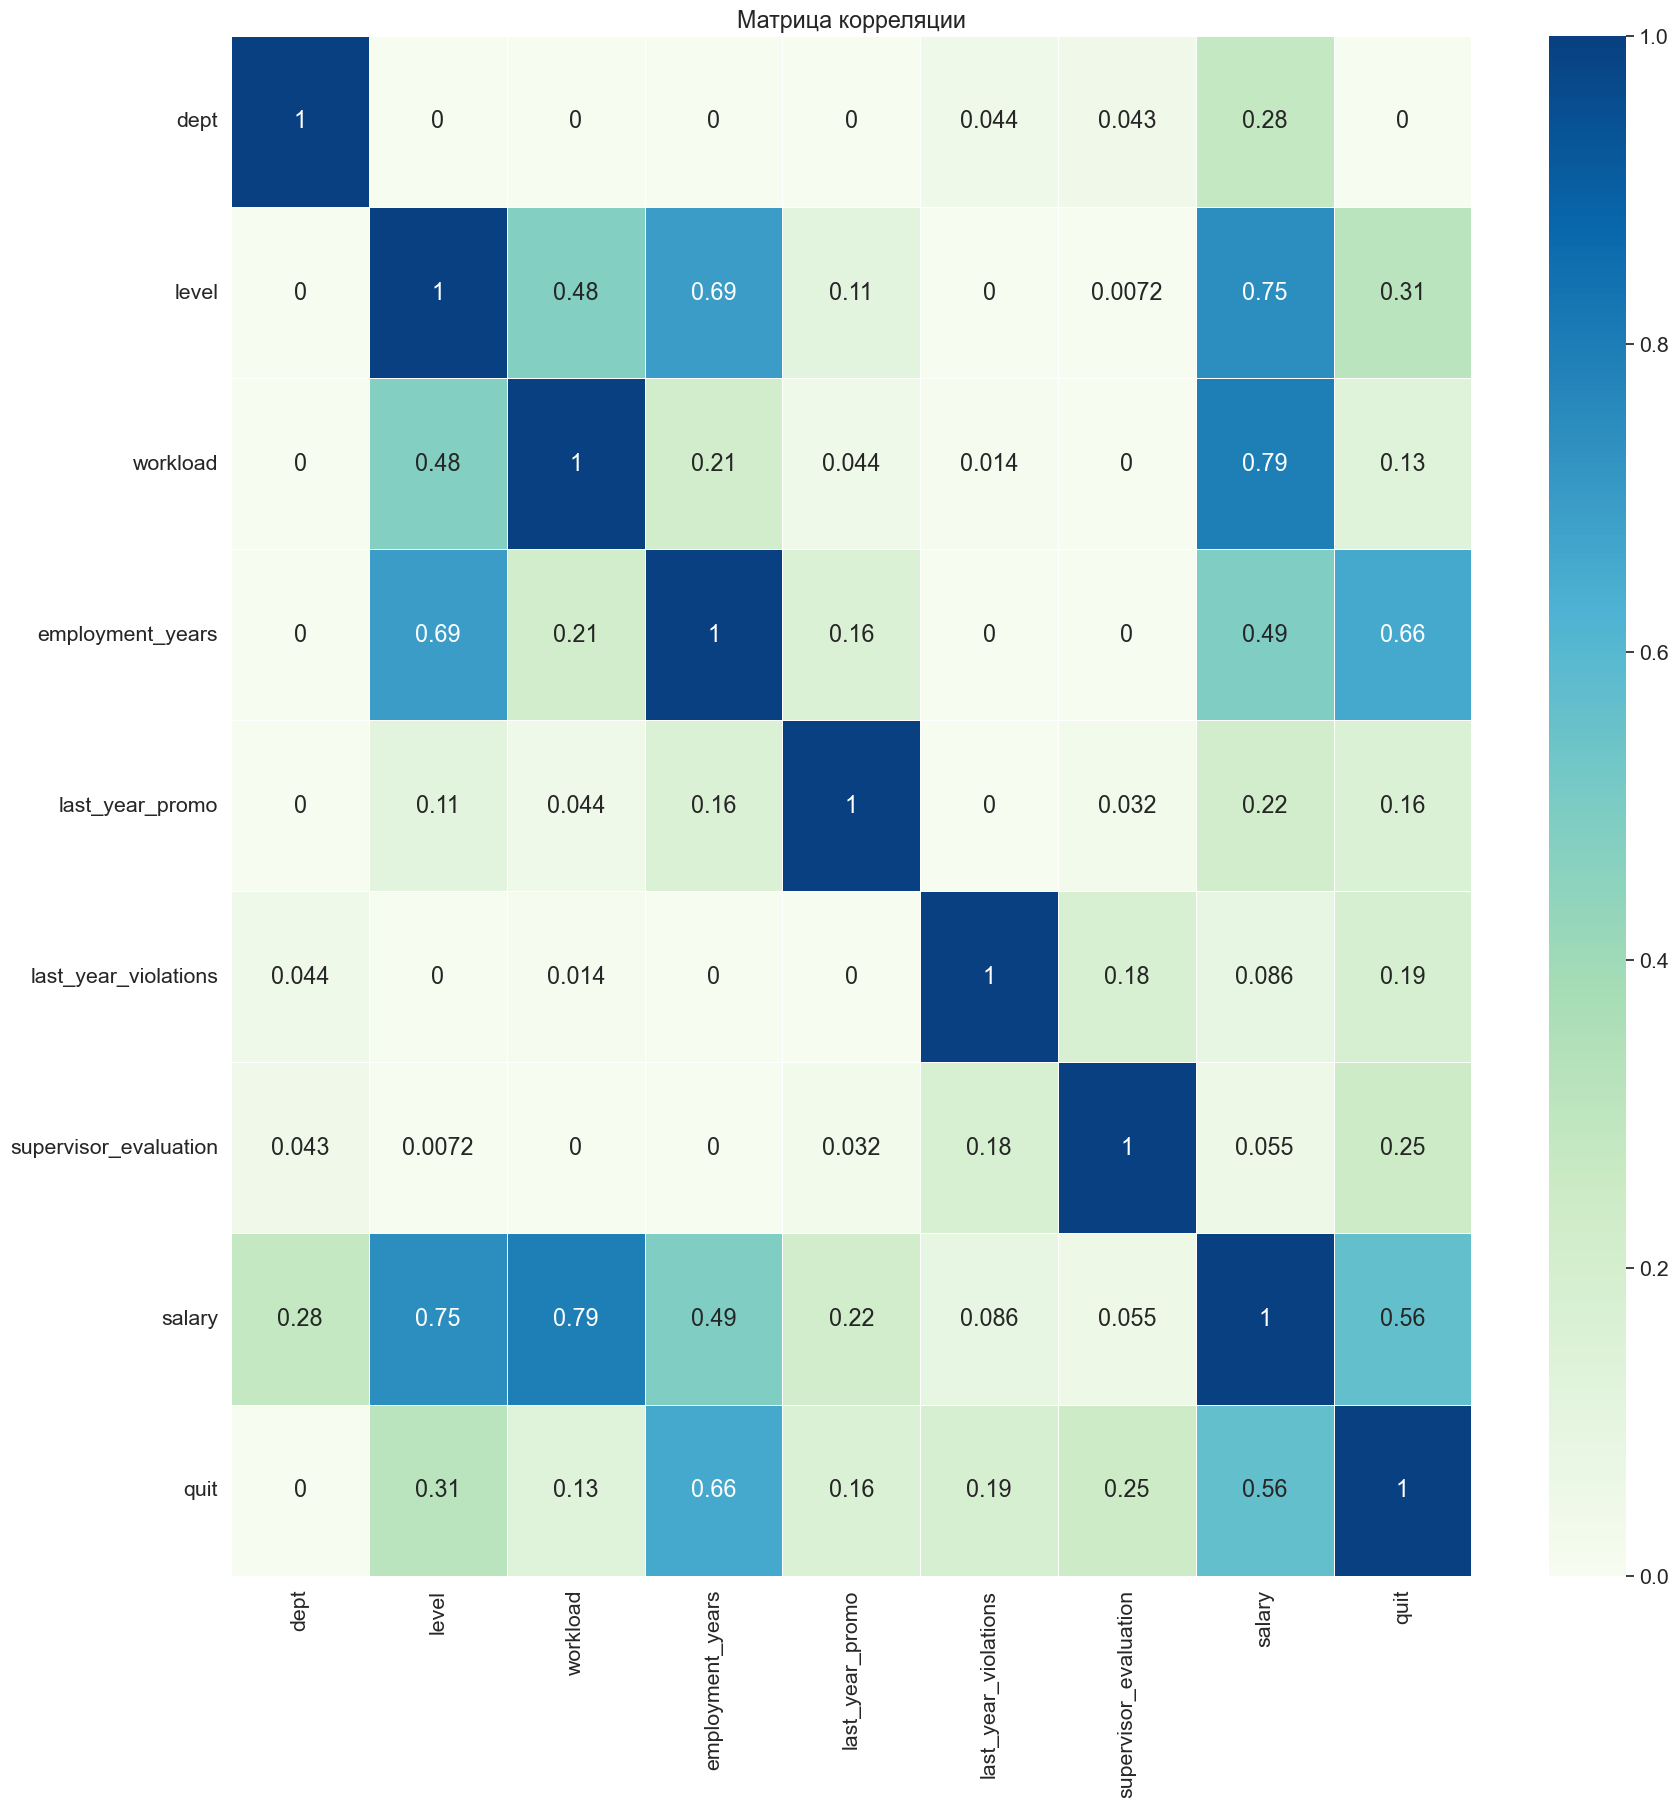

In [60]:
train_quit_1=train_quit.drop(['id'], axis=1)
corr_matrix = train_quit_1.phik_matrix(interval_cols = num_col)
sns.set(font_scale=1.4)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
plt.title('Матрица корреляции')
plt.show()

После исследования данных в train_quit, особой разницы между исследуемыми данными и данными с анализа job_satisfaction не нашли. Стоит отметить только что признак 'quit' достаточно высокий и коррелируется с заарплатой и проработанным количеством лет.

Поделим train_quit на  вспомогательные таблицы - в одной ушедшие во второй оставшиеся. 

In [61]:
df=train_quit[train_quit['quit'] == 'yes']

In [62]:
df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


In [63]:
# создадим список перемен
num=['salary']
# создадим список с названиями графиков 
titles_num= ['длительность работы в компании', 'оценка качества работы сотрудника', 'ежемесячная зарплата сотрудника']

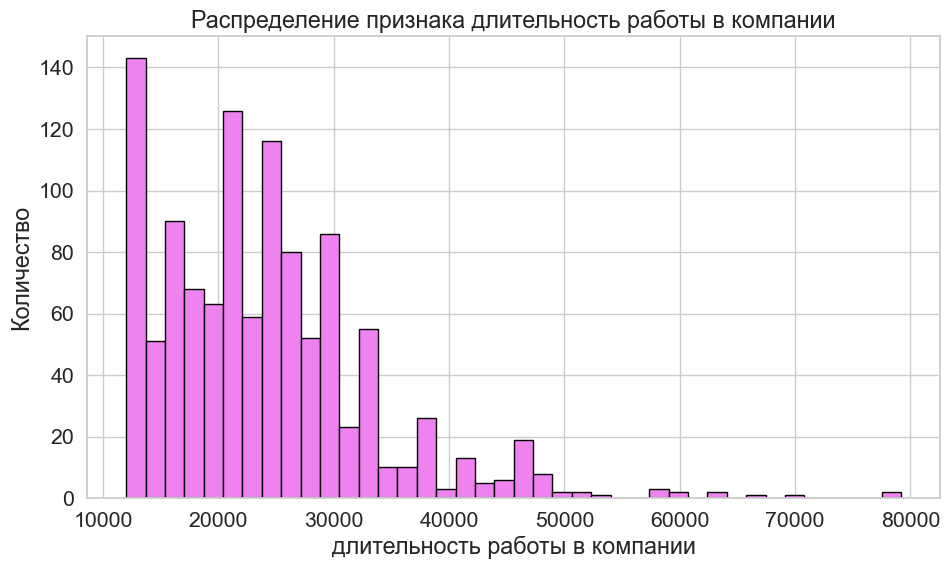

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


In [64]:
#Построим гистограммы и рассмотрим mean,  median, min, max
for i in range(len(num)):
    sns.set_style('whitegrid')
    plt.figure(figsize=(11, 6))
    plt.hist(df[num[i]], color = 'violet', edgecolor = 'black', bins = 40)
    plt.title(f"Распределение признака {titles_num[i]}")
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()
    print(df[num[i]].describe())

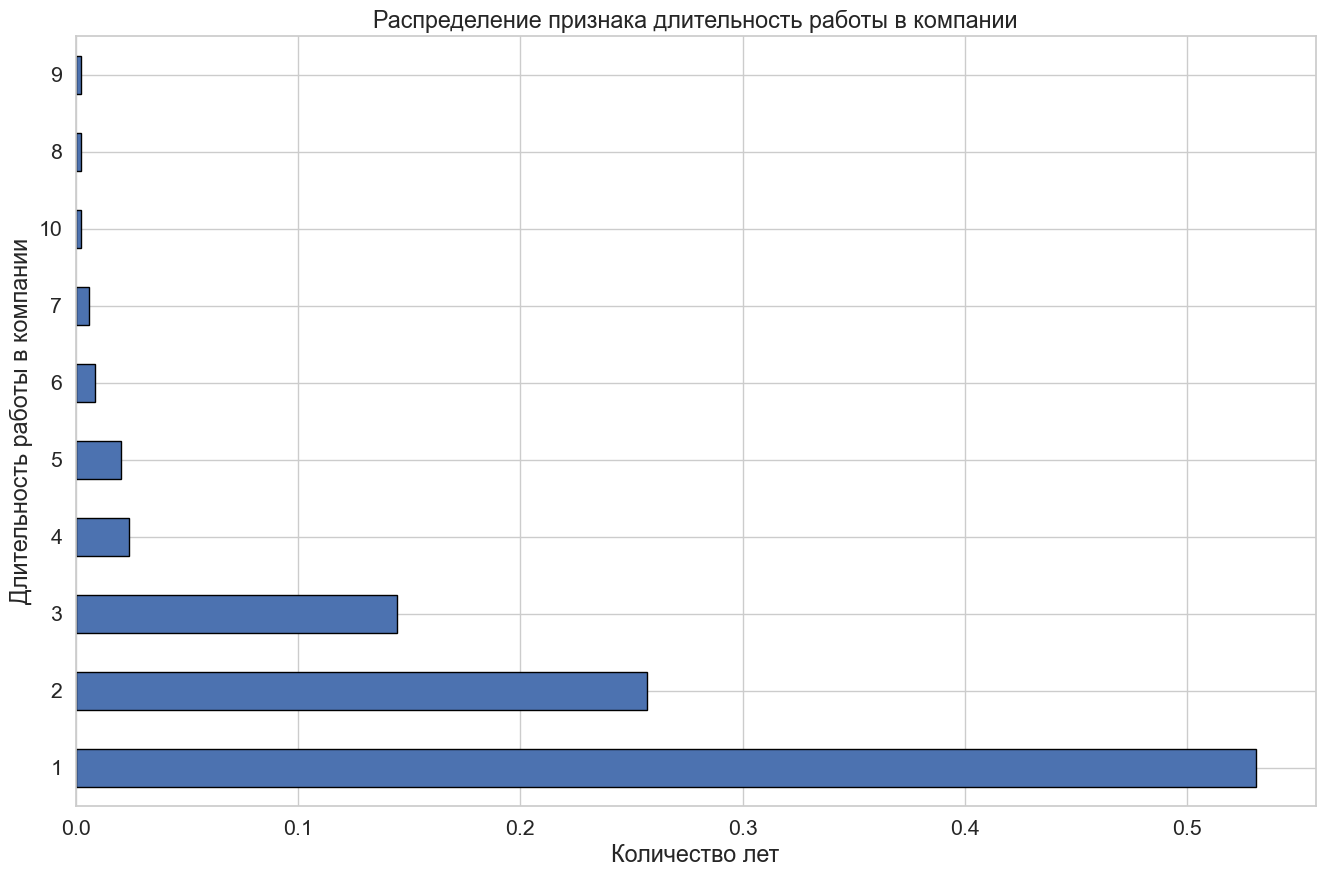

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64


In [65]:
df['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака длительность работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Длительность работы в компании')
plt.show()
print(df['employment_years'].describe())

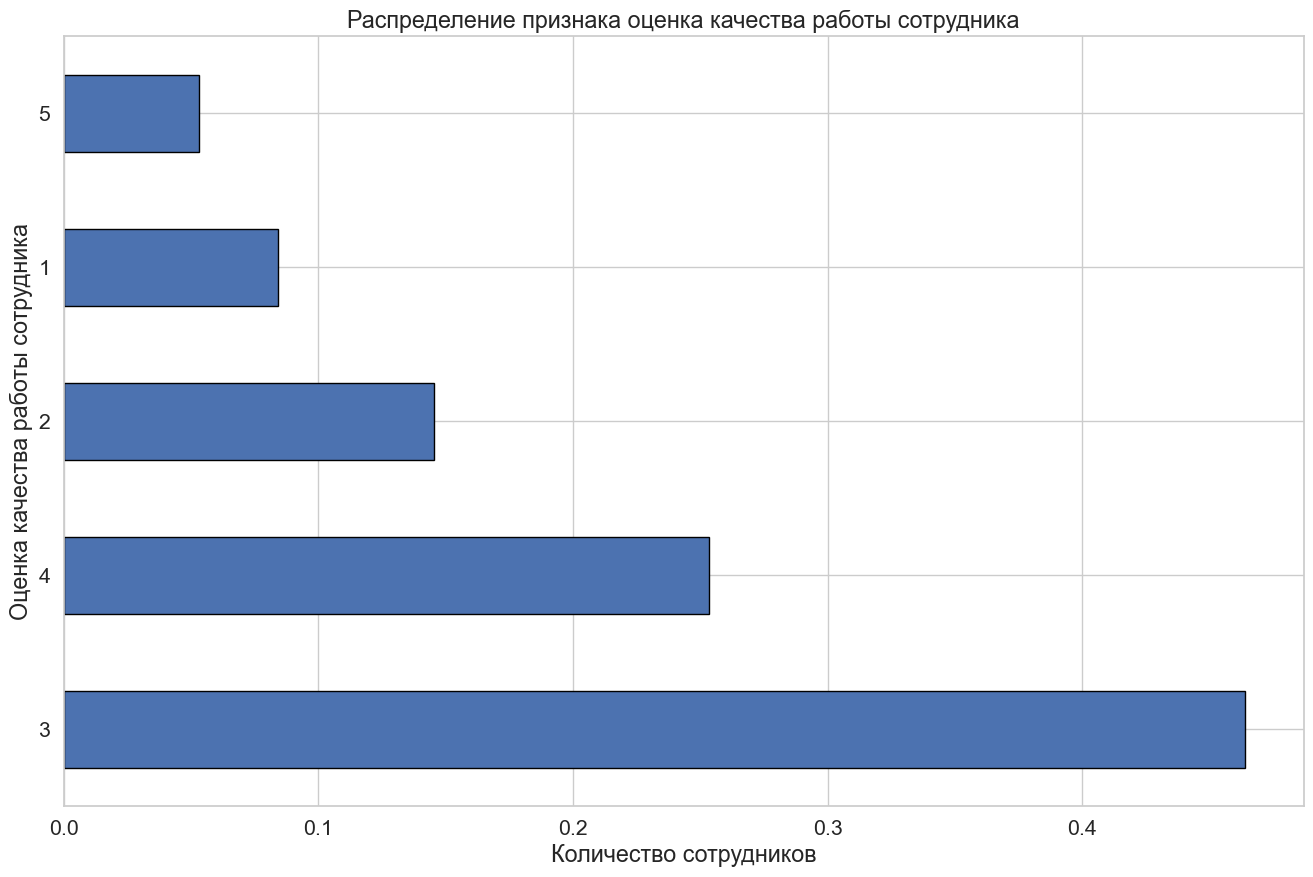

count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [66]:
df['supervisor_evaluation'].value_counts(normalize=True).plot(kind='barh', figsize=(16,10),  ec ='black', grid=True)
plt.title(f'Распределение признака оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы сотрудника')
plt.show()
print(df['supervisor_evaluation'].describe())

In [67]:
# создадим список с категориальных перемен
cat=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# создадим список с названиями графиков 
titles_cat= ['отдел, в котором работает сотрудник', 'уровень занимаемой должности', 'уровень загруженности сотрудника', 'было ли повышение за последний год', 'нарушал ли сотрудник трудовой договор за последний год']

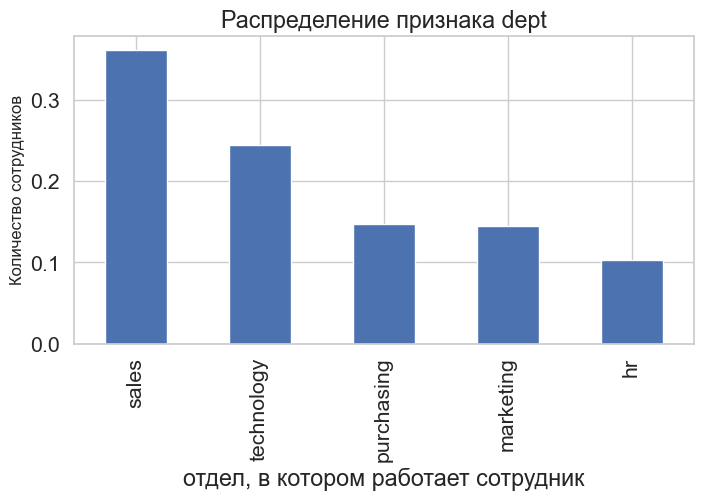

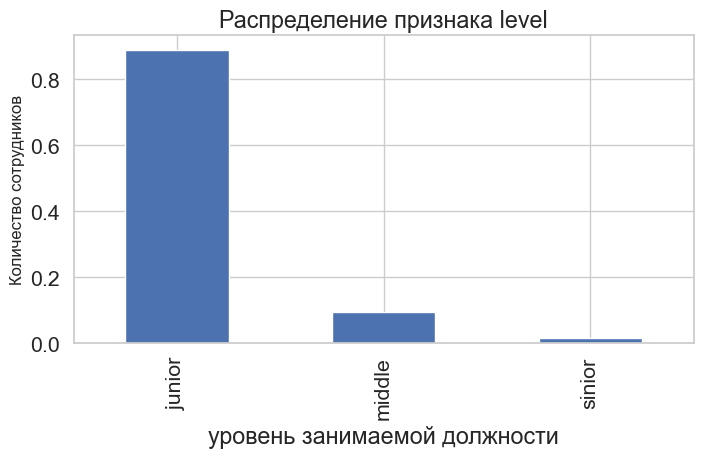

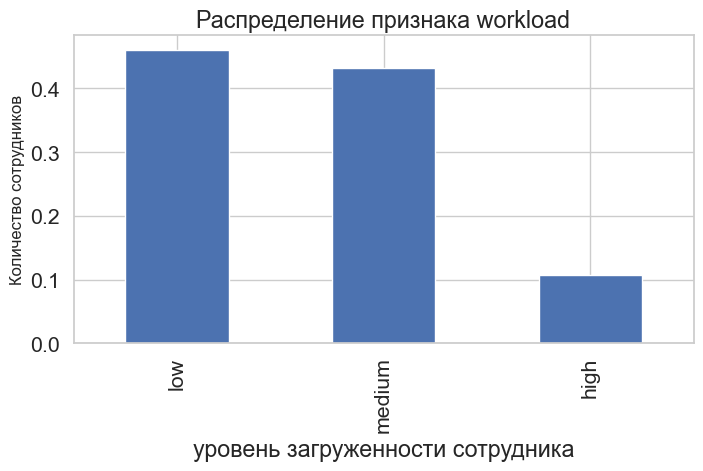

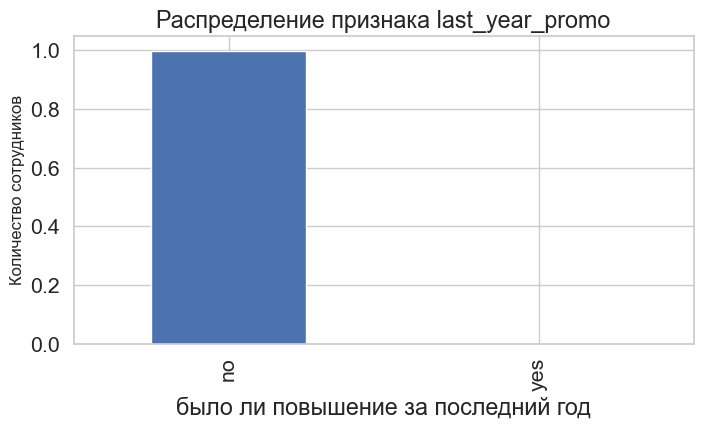

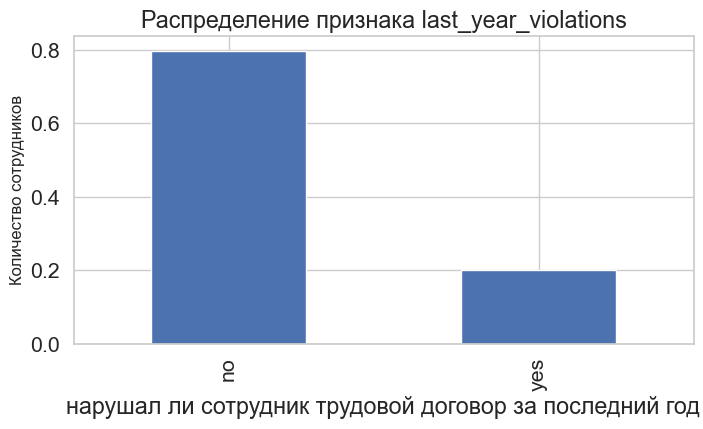

In [68]:
for i in range(len(cat)):
    plt.figure(figsize=(8, 4))
    df[cat[i]].value_counts(normalize=True).plot.bar()
    plt.title(f"Распределение признака {cat[i]}")
    plt.xlabel(titles_cat[i])
    plt.ylabel('Количество сотрудников', size=12)
    plt.show()

Анализируя категориальные признаки во вспомогательной таблице ушедших работников мы видим что больше всего ушедших работников в отделе продаж, junior, с низким уровнем загруженности, без повышения за последний год .

Также мы видим что уровень зарплаты уволенных в среднем на 10000 рублей ниже, оценка качества работников это 3 бала, длительность работы в основном 1 год.


In [69]:
df_1 = test_target.merge(test_target_quit, on='id')
df_yes=df_1[df_1['quit'] == 'yes']
df_no=df_1[df_1['quit'] == 'no']

In [70]:
df_yes.head()

,id,job_satisfaction_rate,quit
2,418490,0.60,yes
4,826430,0.08,yes
20,508688,0.58,yes
29,343440,0.35,yes
30,622918,0.77,yes


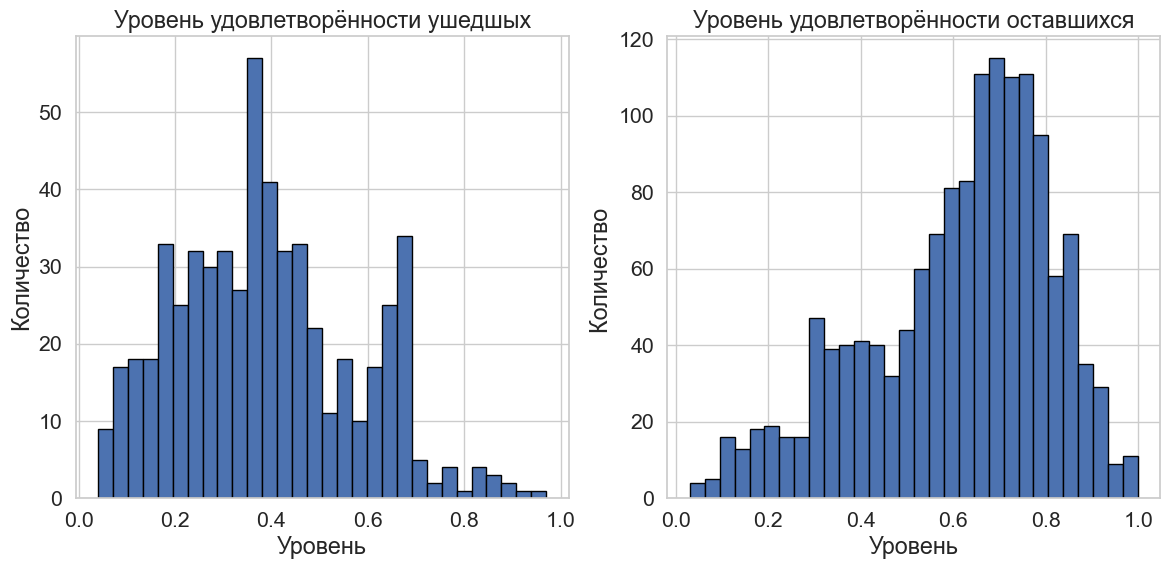

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64


count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(df_yes['job_satisfaction_rate'], bins = 30, ec='black')
ax1.set_title('Уровень удовлетворённости ушедшых')
ax1.grid(True)
ax1.set_xlabel('Уровень')
ax1.set_ylabel('Количество')

ax2.hist(df_no['job_satisfaction_rate'], bins = 30,  ec='black')
ax2.set_title('Уровень удовлетворённости оставшихся')
ax2.grid(True)
ax2.set_xlabel('Уровень')
ax2.set_ylabel('Количество ')

plt.show()
print(df_yes['job_satisfaction_rate'].describe())
df_no['job_satisfaction_rate'].describe()

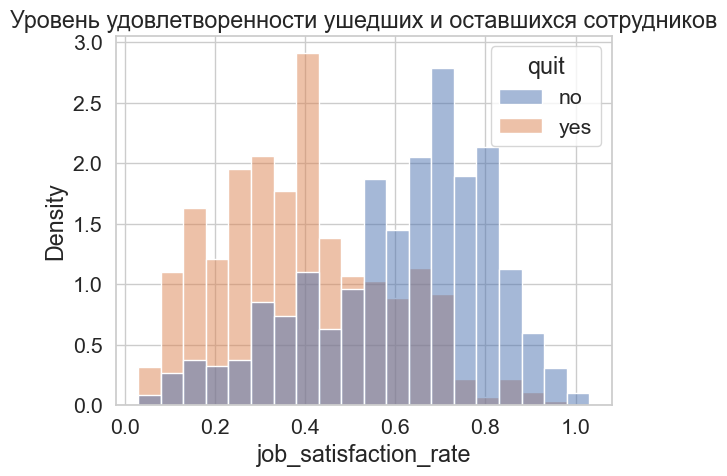

In [72]:
sns.histplot(data=df_1, x="job_satisfaction_rate", binwidth=0.05, hue="quit", stat='density', common_norm=False).set (title='Уровень удовлетворенности ушедших и оставшихся сотрудников')
plt.show()

Анализируя категориальные признаки во вспомогательной таблице ушедших работников мы видим что больше всего ушедших работников в отделе продаж, junior, с низким уровнем загруженности, без повышения за последний год .

Также мы видим что уровень зарплаты уволенных в среднем на 10000 рублей ниже, оценка качества работников это 3 бала, длительность работы в основном 1 год.

Также стоит отметить что утверждение аналитиков подтверждаются - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, что подтверждается распределением признака. Средняя оценка для ушедших работников составила  0.387713
а  для оставшихся 0.612040

##  Добавление нового входного признака задача 2 <a name="feature2"></a>

In [73]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.640000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.840769
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


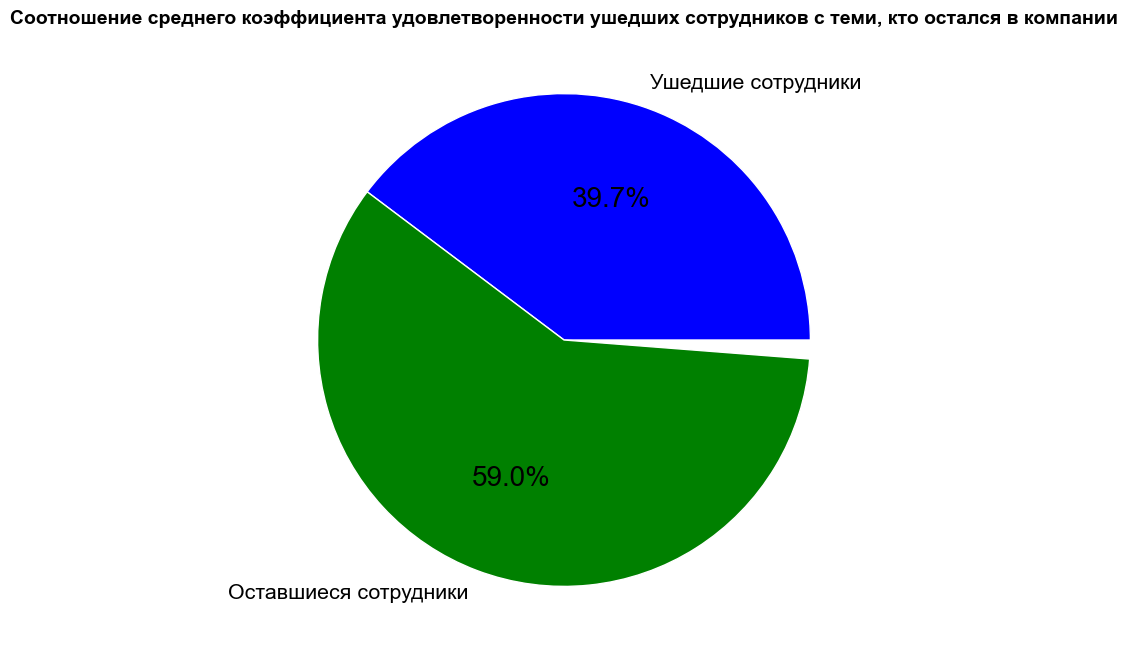

In [74]:
gone = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'yes'].mean()
remained = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'no'].mean()
data = [gone, remained]
labels = ['Ушедшие сотрудники', 'Оставшиеся сотрудники']
plt.figure(figsize=(8,8))
plt.rc('font', size= 20 ) 

fbcolor = ["blue", "green"]

plt.pie(data, labels = labels, colors = fbcolor, autopct='%.1f%%', textprops={'color':'black'}, normalize=False)
plt.title('Соотношение среднего коэффициента удовлетворенности ушедших сотрудников с теми, кто остался в компании', fontsize=14, fontweight="bold", color='black')

plt.show() 

Мы добавили новый признак а также вывели соотношение среднего коэфициента удовлетворенности между ушедшими и оставшимся. Как видим седний коэфициент удовлетворенности для ушедших составил всего 39.8%.

##  Подготовка данных задача 2<a name="prepare2"></a>

- dept, last_year_promo, last_year_violations — нужно кодировать с помощью OneHotEncoder.
- level, workload — нужно кодировать с помощью OrdinalEncoder.
- employment_years, supervisor_evaluation, salary, job_satisfaction_rate - нужно масштабировать.

В признаках пропуски встречаются и обработаем их в пайплайне.
Задачу мультиклассовой классификации тут рассматривать не будем.

In [75]:
test_features['job_satisfaction_rate'] = best_model.predict(test_features)
test_features[test_features.columns[test_features.columns != 'id']].describe()
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.859091
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.652000
3,418655,sales,middle,low,6,no,no,4,19200,0.666000
4,789145,hr,middle,medium,5,no,no,5,40800,0.825556


##  Обучение моделей задача 2 <a name="learn2"></a>

In [76]:
all_features = test_target_quit.merge(test_features, on='id')
descr(all_features)
all_features 

,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.307143
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.206000
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.600000
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.684000
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.495000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   quit                   2000 non-null   object 
 2   dept                   1997 non-null   object 
 3   level                  1999 non-null   object 
 4   workload               1999 non-null   object 
 5   employment_years       2000 non-null   int64  
 6   last_year_promo        2000 non-null   object 
 7   last_year_violations   2000 non-null   object 
 8   supervisor_evaluation  2000 non-null   int64  
 9   salary                 2000 non-null   int64  
 10  job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
quit                     0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.307143
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.206000
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.600000
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.684000
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.495000
...,...,...,...,...,...,...,...,...,...,...,...
1995,836109,yes,sales,junior,high,1,no,no,3,33600,0.608182
1996,180999,yes,purchasing,junior,low,2,no,no,4,12000,0.666000
1997,746018,no,hr,middle,medium,2,no,no,4,46800,0.690000
1998,247658,no,sales,middle,medium,1,no,no,5,38400,0.625000


In [77]:
#train_quit['quit'] = train_quit['quit'].apply(lambda x: 1 if x =='yes' else 0)

In [78]:
#labelencoder = LabelEncoder()
 
#train_quit.loc[:, 'quit'] = labelencoder.fit_transform(train_quit.loc[:, 'quit'])
#all_features.loc[:, 'quit'] = labelencoder.transform(all_features.loc[:, 'quit'])

In [79]:
train_2 = train_quit.drop(['id'], axis=1)
train_2.drop_duplicates(inplace=True)
test_2 = all_features.drop(['quit','id'], axis=1)
target_2 = all_features['quit'] 

In [80]:
RANDOM_STATE = 100
TEST_SIZE = 0.25

X_train = train_2.drop('quit', axis=1)
y_train = train_2['quit'] 
X_test = test_2
y_test = target_2

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level','workload',]

In [81]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)  

In [82]:
   
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 
param_grid = [
     {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]

In [83]:
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

# выводим на экран лучшую модель, её параметры и метрику ROC-AUC на тренировочной выборке
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [84]:
best_model = r_search.best_estimator_

print(f'Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: {round(r_search.best_score_,4)}')
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_score(y_test, r_search.predict_proba(X_test)[:, 1]),4)}')

Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: 0.9017
Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9115


In [85]:
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_score(y_test, r_search.predict_proba(X_test)[:, 1]),4)}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9115


In [86]:
# преобразовываем результаты в датафрейм и выводим результаты на экран
pd.DataFrame(r_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
0,0.005905,1,DecisionTreeClassifier(random_state=100),0.901731,"{'preprocessor__num': 'passthrough', 'models__..."
9,0.008644,2,DecisionTreeClassifier(random_state=100),0.886371,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,0.005562,3,DecisionTreeClassifier(random_state=100),0.886233,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,0.027066,4,DecisionTreeClassifier(random_state=100),0.878488,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,0.007049,5,DecisionTreeClassifier(random_state=100),0.865922,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,0.007213,6,DecisionTreeClassifier(random_state=100),0.865752,"{'preprocessor__num': StandardScaler(), 'model..."
7,0.010942,7,DecisionTreeClassifier(random_state=100),0.857468,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,0.018899,8,DecisionTreeClassifier(random_state=100),0.848199,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,0.018871,9,DecisionTreeClassifier(random_state=100),0.848090,"{'preprocessor__num': StandardScaler(), 'model..."
2,0.018138,10,DecisionTreeClassifier(random_state=100),0.843876,"{'preprocessor__num': 'passthrough', 'models__..."


In [87]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# считаем метрику ROC-AUC для тренировочных и тестовых данных
print('Метрики Dummy Model:')
d_roc_auc_cv = cross_val_score(dummy_model, X_train, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {round(d_roc_auc_cv, 3)}')

# оценка качества модели по метрике ROC-AUC
dummy_roc = roc_auc_score(y_test, dummy_model_preds)
print('ROC-AUC на тестовой выборке:', round(dummy_roc,2))


Метрики Dummy Model:
ROC-AUC на тренировочной выборке: 0.5
ROC-AUC на тестовой выборке: 0.5


Результаты модели DecisionTreeClassifier лучше Dummy Model. Выбранная модель адекватна и эффективна.

##  Оформление выводов задача 2 <a name="resume2"></a>

Мы провели обучение модели. Был построен пайплайн с использование:DecisionTreeClassifier(), KNeighborsClassifier(), RandomForestClassifier(). Обучение происходило используя первоначальные данные а также провели обучения на объединенных данных с вычленением признака. 


Параметры лучшей модели:
- {'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=100)}
Метрика лучшей модели на тренировочной выборке: 0.901

- Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9122

## ОБЩИЕ ВЫВОДЫ <a name="resumefinal"></a>

Мы провели исследование для HR-аналитиков компании «Работа с заботой» . У нас было 2 задачи:

ЗАДАЧИ ПРОЕКТА
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для первой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника
- dept — отдел, в котором работает сотрудник
- level — уровень занимаемой должности
- workload — уровень загруженности сотрудника
- employment_years — длительность работы в компании (в годах)
- last_year_promo — показывает, было ли повышение за последний год
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель
- salary — ежемесячная зарплата сотрудника
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак

Предоставлены данные в нескольких таблицах:
- Тренировочная выборка:
train_job_satisfaction_rate.csv

- Входные признаки тестовой выборки:
test_features.csv

- Целевой признак тестовой выборки:
test_target_job_satisfaction_rate.csv

Для второй задачи мы можем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

Данные в нескольких таблицах: Тренировочная выборка:
- train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче:
- test_features.csv
Целевой признак тестовой выборки:
- test_target_quit.csv

После загрузки данных мы провели их предобработк:
- стандартизация имен признаков ;
- приведение типов данных в нужный формат;

Просмотрели наши категориальнве данные на наличие неявных дубликатов или ошибок при заполнении - ничего подозрительного не обнаруженно.
В двух колонках заменили пустые значения на nan.
- также провели исследование на наличие пропусков и дубликатов.
После проведенного исследования можно сделать следующие выводы:
- основное число работников работают в компании от 2 до 6 лет. В среднем рабочей стаж в компании составляет 3 года.
- стоит отметить что оценка качества сотрудников — хороший середнячок : в основном сотрудники оцениваются на 3 и 4 бала. Но есть и те у кого оценка равна 1. Бар плот показывает что это один человек( кандидат на увольнение).

- несмотря на несколько выбросов средняя зарплата не намного больше медианной и составляет 33 926.70 тысяч рублей. С максимальной в 98400 и минимальной — 12000.
- удовлетворенность сотрудника работой соответствует оценке качества — хороший середнячок. В целом условия и работа неплохие, но можно и лучше.

По категориальным признакам можно сделать следующие выводы:
- основное число работников составляют продавцы, на втором месте технологический отдел;
- по уровню занимаемой должности , все выглядит так как должно -основное число сотрудников это junior, но стоит отметить также значительное число среднего уровня;
- загруженность персонала , также находится в основном на среднем уровне, но компании стоит обратить внимание на достаточно высокий уровень мало загруженных сотрудников.
- видим что в компании за последний год практически не было повышения, что достаточно логично учитывая средний стаж работников — 3 года., но с другой стороны повышения можно использовать как дополнительный стимул для повышения производительности труда.
- по дисциплине стоит отметить достаточно низкий уровень нарушений трудового договора, но все же они есть. Стоит обратить внимание на них и носят ли эти нарушения систематический характер.

По корреляционному анализу можно сказать следующие: высокий уровень корреляции между целевым признаком - уровень удовлетворённости сотрудника работой в компании и отделом, в котором работает сотрудник, уровнем занимаемой должности а также оценка качества работы сотрудника. Но тем не менее сильной корреляционой зависимости между признаками нет. В нашем случае мультиколлинеарность отсутствует. Поэтому ничего удалять не будем. 

Мы провели обучение модели. Был построен пайплайн с использование:DecisionTreeClassifier(),LinearRegression().

 Параметры лучшей модели:
- {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 12, 'models__max_features': 10, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=100)}
- Метрика лучшей модели на тренировочной выборке: -15.18
- Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 15.1814
- Метрика sMAPE лучшей модели на тестовой выборке: 13.6159

Для второй задачи после загрузки данных мы провели их предобработк:
    • стандартизация имен признаков ;
    • приведение типов данных в нужный формат;
    • Просмотрели наши категориальнве данные на наличие неявных дубликатов или ошибок при заполнении - ничего подозрительного не обнаруженно.
В двух колонках заменили пустые значения на nan.
также провели исследование на наличие пропусков и дубликатов.
Анализируя категориальные признаки во вспомогательной таблице ушедших работников мы видим что больше всего ушедших работников в отделе продаж, junior, с низким уровнем загруженности, без повышения за последний год .
Также мы видим что уровень зарплаты уволенных в среднем на 10000 рублей ниже, оценка качества работников это 3 бала, длительность работы в основном 1 год.

Анализируя категориальные признаки во вспомогательной таблице ушедших работников мы видим что больше всего ушедших работников в отделе продаж, junior, с низким уровнем загруженности, без повышения за последний год .
Также мы видим что уровень зарплаты уволенных в среднем на 10000 рублей ниже, оценка качества работников это 3 бала, длительность работы в основном 1 год.
Также стоит отметить что утверждение аналитиков подтверждаются - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, что подтверждается распределением признака. Средняя оценка для ушедших работников составила 0.387713 а для оставшихся 0.612040
Мы добавили новый признак а также вывели соотношение среднего коэфициента удовлетворенности между ушедшими и оставшимся. Как видим седний коэфициент удовлетворенности для ушедших составил всего 39.8%.

Мы провели обучение модели. Был построен пайплайн с использование:DecisionTreeClassifier(), KNeighborsClassifier(), LinearRegression(). Обучение происходило используя первоначальные данные а также провели обучения на объединенных данных с вычленением признака.

- {'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=100)}
- Метрика лучшей модели на тренировочной выборке: 0.901

- Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9122

Рекомендации для бизнеса:

После проведенного анализа мы выяснили что в основном текучка кадров происходит для работников которые работают фактически меньше года, что в принципе нормально.

Стоит компании уделить внимание на повышение коэфициента удовлетворенности: повысить уровень зарплаты и загруженности с введением промежуточных мини премий.